In [4]:
import pandas as pd

# 1) 데이터 로드 (경로를 실제로 수정)
train_path = '/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv'
train_df = pd.read_csv(train_path)

# 2) 3개월 수익률 분포 요약
target_col = '3개월수익률'
desc = train_df[target_col].describe()  # count, mean, std, min, 25%, 50%, 75%, max
quantiles = train_df[target_col].quantile([0.1,0.25,0.5,0.75,0.9]).to_dict()

print("----------- 3개월 수익률 기본 통계 -----------")
print(desc)
print("\n----------- 3개월 수익률 주요 분위수 -----------")
for q, val in quantiles.items():
    print(f"  {int(q*100)}% 분위수: {val:.2f}%")

----------- 3개월 수익률 기본 통계 -----------
count    55044.000000
mean         0.017813
std          0.285055
min         -0.938634
25%         -0.133978
50%         -0.027691
75%          0.102208
max          6.506297
Name: 3개월수익률, dtype: float64

----------- 3개월 수익률 주요 분위수 -----------
  10% 분위수: -0.23%
  25% 분위수: -0.13%
  50% 분위수: -0.03%
  75% 분위수: 0.10%
  90% 분위수: 0.28%


Percentile Rank 기반 Value Factor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# 1) 데이터 로드
train_path = '/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv'
test_path  = '/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv'
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# 2) Value 팩터 컬럼 정의
value_cols = ['PER', 'PBR', 'PSR', 'roe_per_ratio']

# 3) Percentile Rank 계산 (0~1 사이 실수)
#    train_df['value_label'] 컬럼으로 저장
target_col = '3개월수익률'
train_df['value_label'] = train_df[target_col].rank(pct=True)

# 4) 결측치 처리
X_train = train_df[value_cols].fillna(train_df[value_cols].mean())
X_test  = test_df [value_cols].fillna(train_df[value_cols].mean())
y_train = train_df['value_label']

# 5) 파이프라인 정의: 스케일링 + RandomForest 회귀
pipe_value_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

# 6) 학습
pipe_value_reg.fit(X_train, y_train)

# 7) 테스트 데이터 예측 (0~1 사이 점수)
test_df['pred_value_score'] = pipe_value_reg.predict(X_test)

# 8) 예측 점수의 분포 확인
print("=== pred_value_score 분포 (기본 통계) ===")
print(test_df['pred_value_score'].describe())

# 9) Top20 추출 (Score 내림차순)
top20_value = (test_df
               .sort_values(by='pred_value_score', ascending=False)
               .head(20)
               .loc[:, ['기준월', '종목코드', '회사명', 'pred_value_score']])
print("\n=== Value 팩터 Top 20 종목 ===")
print(top20_value.reset_index(drop=True))

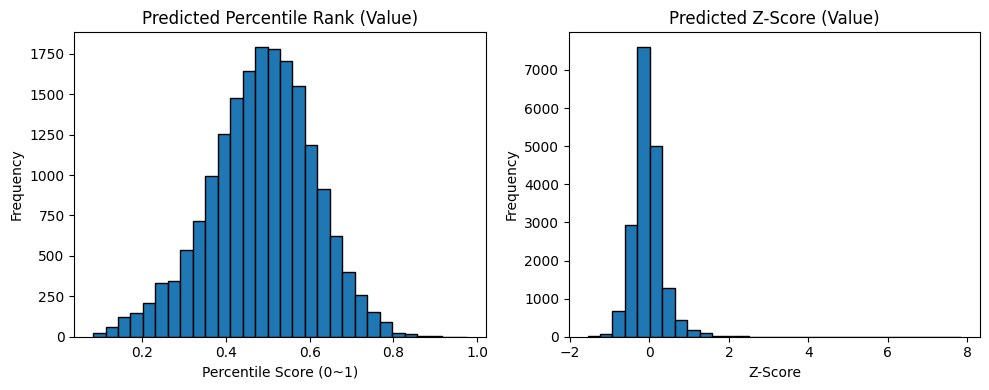

=== Top 20 (Percentile Rank 기준) ===
           기준월    종목코드       회사명  pred_prank
0   2024-12-01    7390      네이처셀    0.975375
1   2024-02-01  244460      올리패스    0.901944
2   2024-02-01  300080       플리토    0.898976
3   2024-03-01  244460      올리패스    0.893557
4   2024-04-01   65350    신성델타테크    0.880737
5   2024-08-01  950140     잉글우드랩    0.856539
6   2024-05-01  950140     잉글우드랩    0.848598
7   2024-10-01  950140     잉글우드랩    0.847980
8   2024-04-01  950140     잉글우드랩    0.845105
9   2024-01-01  300080       플리토    0.844292
10  2024-05-01  319400     현대무벡스    0.841497
11  2024-07-01    2710     TCC스틸    0.839268
12  2024-01-01  303030      지니틱스    0.838749
13  2024-11-01  249420      일동제약    0.837597
14  2024-10-01  214150      클래시스    0.835643
15  2024-02-01  218410     RFHIC    0.834119
16  2024-02-01  303030      지니틱스    0.833460
17  2024-08-01   47050  포스코인터내셔널    0.829739
18  2024-05-01  330860     네패스아크    0.827131
19  2024-11-01   39200      오스코텍    0.826632

=== Top 20 (Z-Scor

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# --------------------------------------------
# 0. DataFrame 준비 
# --------------------------------------------
train_path = '/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv'
test_path  = '/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv'
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# --------------------------------------------
# 1. Value 팩터 컬럼 정의
# --------------------------------------------
value_cols = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
target_col = '3개월수익률'  # 학습용 타깃 컬럼

# --------------------------------------------
# 2. Percentile Rank 기반 레이블 생성
# --------------------------------------------
# train_df['value_prank'] = train_df[target_col].rank(pct=True)
# X_train_pr, y_train_pr, X_test_pr 준비
X_train_pr = train_df[value_cols].fillna(train_df[value_cols].mean())
X_test_pr  = test_df [value_cols].fillna(train_df[value_cols].mean())
y_train_pr = train_df['3개월수익률'].rank(pct=True)

# --------------------------------------------
# 3. Percentile 회귀 파이프라인 학습
# --------------------------------------------
pipe_pr = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_pr.fit(X_train_pr, y_train_pr)

# Test 데이터에 대한 예측(0~1 사이 Percentile Score)
test_df['pred_prank'] = pipe_pr.predict(X_test_pr)

# --------------------------------------------
# 4. Z-Score 기반 레이블 생성
# --------------------------------------------
mu    = train_df[target_col].mean()
sigma = train_df[target_col].std()
train_df['value_zscore'] = (train_df[target_col] - mu) / sigma

X_train_z = train_df[value_cols].fillna(train_df[value_cols].mean())
X_test_z  = test_df [value_cols].fillna(train_df[value_cols].mean())
y_train_z = train_df['value_zscore']

# --------------------------------------------
# 5. Z-Score 회귀 파이프라인 학습
# --------------------------------------------
pipe_z = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_z.fit(X_train_z, y_train_z)

# Test 데이터에 대한 예측(Z-Score)
test_df['pred_zscore'] = pipe_z.predict(X_test_z)

# --------------------------------------------
# 6. 예측 분포 시각화
# --------------------------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(test_df['pred_prank'], bins=30, edgecolor='black')
plt.title('Predicted Percentile Rank (Value)')
plt.xlabel('Percentile Score (0~1)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_df['pred_zscore'], bins=30, edgecolor='black')
plt.title('Predicted Z-Score (Value)')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# --------------------------------------------
# 7. Top 20 종목 추출 및 출력
# --------------------------------------------
top20_pr = (test_df
            .sort_values(by='pred_prank', ascending=False)
            .head(20)
            .loc[:, ['기준월','종목코드','회사명','pred_prank']]
            .reset_index(drop=True))

top20_z = (test_df
           .sort_values(by='pred_zscore', ascending=False)
           .head(20)
           .loc[:, ['기준월','종목코드','회사명','pred_zscore']]
           .reset_index(drop=True))

print("=== Top 20 (Percentile Rank 기준) ===")
print(top20_pr)

print("\n=== Top 20 (Z-Score 기준) ===")
print(top20_z)

In [ ]:
import pandas as pd

# --- 1) Pred_prank 기준 Top 20 --- #
top20_pr = (test_df
            .sort_values(by='pred_prank', ascending=False)
            .head(20)
            .copy())

# --- 2) Pred_zscore 기준 Top 20 --- #
top20_z = (test_df
           .sort_values(by='pred_zscore', ascending=False)
           .head(20)
           .copy())

# --- 3) 실현 3개월 수익률 평균/중앙값 계산 --- #
def summarize_rets(df, label):
    actuals = df['3개월수익률']  # 실제 3개월 뒤 수익률(%)
    return {
        f'{label}_count': len(actuals),
        f'{label}_mean_%': actuals.mean(),
        f'{label}_median_%': actuals.median(),
        f'{label}_std_%': actuals.std()
    }

pr_stats = summarize_rets(top20_pr, 'PR')
z_stats  = summarize_rets(top20_z, 'ZS')

summary_df = pd.DataFrame([pr_stats, z_stats]).T
print("\n=== Top20 실현 3M 수익률 비교 (Percentile vs Z-Score) ===")
print(summary_df)


=== Top20 실현 3M 수익률 비교 (Percentile vs Z-Score) ===
                     0          1
PR_count     20.000000        NaN
PR_mean_%     0.163280        NaN
PR_median_%   0.065097        NaN
PR_std_%      0.543964        NaN
ZS_count           NaN  20.000000
ZS_mean_%          NaN  -0.023943
ZS_median_%        NaN  -0.153304
ZS_std_%           NaN   0.431646


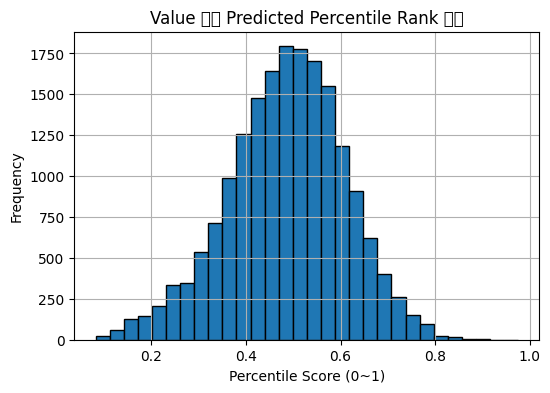

=== 최종 Value 팩터 Top 20 종목 (Percentile Rank 기준) ===
           기준월    종목코드       회사명  pred_value_score
0   2024-12-01    7390      네이처셀          0.975375
1   2024-02-01  244460      올리패스          0.901944
2   2024-02-01  300080       플리토          0.898976
3   2024-03-01  244460      올리패스          0.893557
4   2024-04-01   65350    신성델타테크          0.880737
5   2024-08-01  950140     잉글우드랩          0.856539
6   2024-05-01  950140     잉글우드랩          0.848598
7   2024-10-01  950140     잉글우드랩          0.847980
8   2024-04-01  950140     잉글우드랩          0.845105
9   2024-01-01  300080       플리토          0.844292
10  2024-05-01  319400     현대무벡스          0.841497
11  2024-07-01    2710     TCC스틸          0.839268
12  2024-01-01  303030      지니틱스          0.838749
13  2024-11-01  249420      일동제약          0.837597
14  2024-10-01  214150      클래시스          0.835643
15  2024-02-01  218410     RFHIC          0.834119
16  2024-02-01  303030      지니틱스          0.833460
17  2024-08-01   47050  포스코인터내셔

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# -----------------------------------------------------------------------------
# 1. Value 팩터 피처 정의
# -----------------------------------------------------------------------------
value_cols = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
target_col = '3개월수익률'

# -----------------------------------------------------------------------------
# 2. Percentile Rank 레이블 생성
# -----------------------------------------------------------------------------
# - train 데이터에서 3개월 수익률이 전체 중 몇 % 위치인지(0~1)로 표현
train_df['value_prank'] = train_df[target_col].rank(pct=True)

# 학습/테스트용 특성(X) 및 레이블(y) 준비
X_train_pr = train_df[value_cols].fillna(train_df[value_cols].mean())
y_train_pr = train_df['value_prank']
X_test_pr  = test_df[value_cols].fillna(train_df[value_cols].mean())

# -----------------------------------------------------------------------------
# 3. Percentile 회귀 모델 학습 (RandomForestRegressor 사용)
# -----------------------------------------------------------------------------
pipe_value = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_value.fit(X_train_pr, y_train_pr)

# -----------------------------------------------------------------------------
# 4. 테스트 데이터 예측: pred_value_score (0~1 사이 Percentile 점수)
# -----------------------------------------------------------------------------
test_df['pred_value_score'] = pipe_value.predict(X_test_pr)

# -----------------------------------------------------------------------------
# 5. 예측 분포 시각화 (옵션)
# -----------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.hist(test_df['pred_value_score'], bins=30, edgecolor='black')
plt.title('Value 팩터 Predicted Percentile Rank 분포')
plt.xlabel('Percentile Score (0~1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# 6. Top 20 종목 추출
# -----------------------------------------------------------------------------
top20_value = (
    test_df
    .sort_values(by='pred_value_score', ascending=False)
    .head(20)
    .loc[:, ['기준월', '종목코드', '회사명', 'pred_value_score']]
    .reset_index(drop=True)
)

print("=== 최종 Value 팩터 Top 20 종목 (Percentile Rank 기준) ===")
print(top20_value)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  2 → Silhouette Score = 0.9977


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  3 → Silhouette Score = 0.9936


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  4 → Silhouette Score = 0.9921


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  5 → Silhouette Score = 0.9924


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  6 → Silhouette Score = 0.9913


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  7 → Silhouette Score = 0.9899


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  8 → Silhouette Score = 0.9908


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k =  9 → Silhouette Score = 0.9882


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

k = 10 → Silhouette Score = 0.9884

==> Selected Optimal k = 2



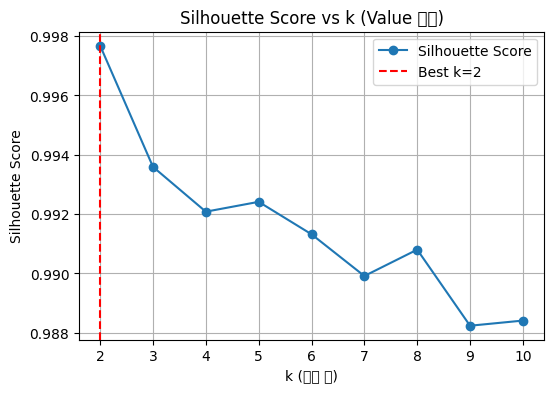

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.13/lib/p

=== 투스텝(클러스터별 전용 모델) 방식 Top20 ===
           기준월    종목코드     회사명  val_cluster  pred_value_score_cluster
0   2024-12-01    7390    네이처셀            0                  0.978600
1   2024-03-01  244460    올리패스            0                  0.921002
2   2024-02-01  300080     플리토            0                  0.917817
3   2024-02-01  244460    올리패스            0                  0.915534
4   2024-12-01  227100     퀀텀온            1                  0.886026
5   2024-06-01  119650   KC코트렐            1                  0.886026
6   2024-05-01  119650   KC코트렐            1                  0.886026
7   2024-04-01  119650   KC코트렐            1                  0.886026
8   2024-04-01   65350  신성델타테크            0                  0.870524
9   2024-05-01  330860   네패스아크            0                  0.858445
10  2024-08-01  950140   잉글우드랩            0                  0.857700
11  2024-01-01  244460    올리패스            0                  0.855725
12  2024-07-01    2710   TCC스틸            0             

In [15]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 0. train_df, test_df 준비
#    train_df.columns 예시:
#    ['기준월','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률', ...]
#    test_df.columns 예시:
#    ['기준월','회사명','PER','PBR','PSR','roe_per_ratio', ...]
# ---------------------------------------------------

# 1. Value 팩터용 피처 정의
value_feats = ['PER', 'PBR', 'PSR', 'roe_per_ratio']

# 2. train 데이터 결측치 처리 + 표준화
X_val_train = train_df[value_feats].fillna(train_df[value_feats].mean())
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_val_train)

# 3. Silhouette Score를 활용해 최적 k 탐색
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"k = {k:2d} → Silhouette Score = {sil:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"\n==> Selected Optimal k = {best_k}\n")

# 4. Silhouette 곡선 시각화 (옵션)
plt.figure(figsize=(6,4))
plt.plot(list(k_range), sil_scores, marker='o', label='Silhouette Score')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.title('Silhouette Score vs k (Value 팩터)')
plt.xlabel('k (군집 수)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# 5. Optimal k로 KMeans 학습 & 클러스터 레이블 생성
kmeans_opt = KMeans(n_clusters=best_k, random_state=42)
train_df['val_cluster'] = kmeans_opt.fit_predict(X_scaled)

# test 데이터에도 동일 스케일러+KMeans 활용
X_val_test   = test_df[value_feats].fillna(train_df[value_feats].mean())
X_scaled_test = scaler_cluster.transform(X_val_test)
test_df['val_cluster'] = kmeans_opt.predict(X_scaled_test)

# -------------------------------------------------------
# 6. Two-Step 구조: 클러스터별 회귀 모델 학습 & 예측
# -------------------------------------------------------
# 6-1) Percentile Rank 레이블 생성 (3개월 수익률)
train_df['value_prank'] = train_df['3개월수익률'].rank(pct=True)

cluster_models = {}
test_preds_by_cluster = {}

from sklearn.ensemble import RandomForestRegressor

for c in range(best_k):
    # 6-2) 해당 군집 데이터 필터링 및 학습
    subset = train_df[train_df['val_cluster'] == c]
    X_c = subset[value_feats].fillna(train_df[value_feats].mean())
    y_c = subset['value_prank']

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ])
    pipe.fit(X_c, y_c)
    cluster_models[c] = pipe

    # 6-3) test_df 중 같은 군집에 속하는 행 예측
    idx_test_c = test_df[test_df['val_cluster'] == c].index
    X_test_c   = test_df.loc[idx_test_c, value_feats].fillna(train_df[value_feats].mean())
    preds_c    = pipe.predict(X_test_c)
    test_preds_by_cluster[c] = (idx_test_c, preds_c)

# 6-4) 클러스터별 예측 결과를 test_df['pred_value_score_cluster']에 채우기
test_df['pred_value_score_cluster'] = np.nan
for c, (idxs, preds) in test_preds_by_cluster.items():
    test_df.loc[idxs, 'pred_value_score_cluster'] = preds

# -------------------------------------------------------
# 7. Single Model + Cluster Label One-Hot 포함 구조
# -------------------------------------------------------
# 7-1) One-Hot 인코딩 (sparse_output=False 로 수정)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cluster_ohe_train = ohe.fit_transform(train_df[['val_cluster']])
cluster_ohe_test  = ohe.transform(test_df[['val_cluster']])

# 7-2) value_feats + one-hot 군집 레이블을 합쳐서 전체 피처 매트릭스 구성
X_train_full = np.hstack([
    train_df[value_feats].fillna(train_df[value_feats].mean()).values,
    cluster_ohe_train
])
y_train_full = train_df['value_prank']

X_test_full = np.hstack([
    test_df[value_feats].fillna(train_df[value_feats].mean()).values,
    cluster_ohe_test
])

# 7-3) 단일 회귀 모델 학습 & 예측
pipe_full = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_full.fit(X_train_full, y_train_full)
test_df['pred_value_score_with_cluster'] = pipe_full.predict(X_test_full)

# -------------------------------------------------------
# 8. 결과 비교: Two-Step vs Single-Model + Cluster
# -------------------------------------------------------
top20_cluster_by_step = (
    test_df
    .sort_values(by='pred_value_score_cluster', ascending=False)
    .head(20)
    .loc[:, ['기준월','종목코드','회사명','val_cluster','pred_value_score_cluster']]
    .reset_index(drop=True)
)

top20_cluster_full = (
    test_df
    .sort_values(by='pred_value_score_with_cluster', ascending=False)
    .head(20)
    .loc[:, ['기준월','종목코드','회사명','val_cluster','pred_value_score_with_cluster']]
    .reset_index(drop=True)
)

print("=== 투스텝(클러스터별 전용 모델) 방식 Top20 ===")
print(top20_cluster_by_step)

print("\n=== 군집 레이블 포함 모델 방식 Top20 ===")
print(top20_cluster_full)

In [16]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------
# (1) 가정: train_df, test_df는 이미 DataFrame으로 메모리에 로드되어 있음
#     - train_df 컬럼: ['기준월','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률', ...]
#     - test_df 컬럼:  ['기준월','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률', ...]
# --------------------------------------------

# 1. Value 팩터 정의
value_feats = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
target_col   = '3개월수익률'

# (잠재적) test_df에서 타깃이 NaN인 행 제거
test_df = test_df.dropna(subset=[target_col]).reset_index(drop=True)

# -------------------------------------------------------------------
# 1. Baseline: Percentile Rank 회귀
# -------------------------------------------------------------------
# 1.1. train_df에 Percentile Rank 레이블 생성 (0~1 실수)
train_df['value_prank'] = train_df[target_col].rank(pct=True)

# 1.2. 학습/테스트용 X, y 준비
X_train_base = train_df[value_feats].fillna(train_df[value_feats].mean())
y_train_base = train_df['value_prank']
X_test_base  = test_df[value_feats].fillna(train_df[value_feats].mean())

# 1.3. 회귀 파이프라인 정의 및 학습
pipe_base = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_base.fit(X_train_base, y_train_base)

# 1.4. Test 데이터 예측(0~1 사이 Percentile 스코어)
test_df['pred_base'] = pipe_base.predict(X_test_base)

# -------------------------------------------------------------------
# 2. Two-Step: KMeans 클러스터링 + 클러스터별 전용 회귀
# -------------------------------------------------------------------
# 2.1. train Data에서 결측치 처리 후 표준화
X_val_train = X_train_base.copy()  # Value 피처만
scaler_cluster = StandardScaler().fit(X_val_train)
X_scaled_train = scaler_cluster.transform(X_val_train)

# 2.2. Silhouette Score로 최적 k 탐색 (2~6 범위)
sil_scores = []
k_range = range(2, 7)  # 군집 2~6개
for k in k_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    labels_tmp = kmeans_tmp.fit_predict(X_scaled_train)
    sil = silhouette_score(X_scaled_train, labels_tmp)
    sil_scores.append(sil)
best_k = k_range[np.argmax(sil_scores)]
print(f">>> Optimal k for KMeans: {best_k}")

# 2.3. 최적 k로 실제 KMeans 학습 & train_df에 val_cluster 컬럼 추가
kmeans = KMeans(n_clusters=best_k, random_state=42)
train_df['val_cluster'] = kmeans.fit_predict(X_scaled_train)

# 2.4. test_df에도 동일 스케일러+KMeans를 적용하여 군집 라벨 생성
X_val_test = test_df[value_feats].fillna(train_df[value_feats].mean())
X_scaled_test = scaler_cluster.transform(X_val_test)
test_df['val_cluster'] = kmeans.predict(X_scaled_test)

# 2.5. train_df에 Percentile Rank 레이블 재확인
train_df['value_prank'] = train_df[target_col].rank(pct=True)

# 2.6. 군집별 전용 회귀 모델 학습 및 예측 결과 저장
cluster_models = {}
test_df['pred_twostep'] = np.nan  # 초기화

for c in range(best_k):
    # 해당 군집 데이터 subset
    subset = train_df[train_df['val_cluster'] == c]
    X_c = subset[value_feats].fillna(train_df[value_feats].mean())
    y_c = subset['value_prank']

    # 클러스터별 RandomForest 회귀 파이프라인
    pipe_c = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ])
    pipe_c.fit(X_c, y_c)
    cluster_models[c] = pipe_c

    # test_df 중 같은 군집에 속하는 행 인덱스
    idxs = test_df[test_df['val_cluster'] == c].index
    X_test_c = test_df.loc[idxs, value_feats].fillna(train_df[value_feats].mean())
    # 해당 군집 전용 모델 예측
    test_df.loc[idxs, 'pred_twostep'] = pipe_c.predict(X_test_c)

# -------------------------------------------------------------------
# 3. Label-Included: KMeans + One-Hot 군집 레이블 포함 단일 회귀
# -------------------------------------------------------------------
# 3.1. One-Hot 인코딩 (sparse_output=False 로 설정)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cluster_ohe_train = ohe.fit_transform(train_df[['val_cluster']])
cluster_ohe_test  = ohe.transform(test_df[['val_cluster']])

# 3.2. Value 피처 + One-Hot 군집 라벨을 합친 X_train_full, X_test_full 생성
X_train_full = np.hstack([
    train_df[value_feats].fillna(train_df[value_feats].mean()).values,
    cluster_ohe_train
])
y_train_full = train_df['value_prank']

X_test_full = np.hstack([
    test_df[value_feats].fillna(train_df[value_feats].mean()).values,
    cluster_ohe_test
])

# 3.3. 단일 회귀 모델 학습 & 예측
pipe_full = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_full.fit(X_train_full, y_train_full)
test_df['pred_labelinc'] = pipe_full.predict(X_test_full)

# -------------------------------------------------------------------
# 4. 세 모델 성능 비교 지표 계산 함수 정의
#    - Top20의 실제 3개월 수익률 평균, 중앙값, 표준편차, 승률(>0 비율)
# -------------------------------------------------------------------
def evaluate_top20(df, pred_col):
    top20 = df.sort_values(by=pred_col, ascending=False).head(20)
    rets = top20[target_col]
    return {
        'mean_return_%':    rets.mean(),
        'median_return_%':  rets.median(),
        'std_return_%':     rets.std(),
        'win_rate':        float((rets > 0).mean())
    }

# 4.1. 각 방식별 평가
results = {
    'Baseline':     evaluate_top20(test_df, 'pred_base'),
    'Two-Step':     evaluate_top20(test_df, 'pred_twostep'),
    'Label-Included': evaluate_top20(test_df, 'pred_labelinc')
}

# 4.2. 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results).T
print("\n=== 세 가지 방식 성능 비교 (Top20 실제 3M 수익률) ===")
print(results_df)

>>> Optimal k for KMeans: 2

=== 세 가지 방식 성능 비교 (Top20 실제 3M 수익률) ===
                mean_return_%  median_return_%  std_return_%  win_rate
Baseline             0.163280         0.065097      0.543964      0.65
Two-Step             0.113788        -0.011065      0.583362      0.50
Label-Included       0.163280         0.065097      0.543964      0.65


In [17]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------
# (1) 가정: train_df, test_df는 이미 DataFrame으로 메모리에 로드되어 있고
#     '산업군' 컬럼이 존재합니다.
#     - train_df: ['기준월','종목코드','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률','산업군', ...]
#     - test_df:  ['기준월','종목코드','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률','산업군', ...]
# --------------------------------------------

# 1. Value 팩터 정의
value_feats  = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
industry_col = '산업군'
target_col   = '3개월수익률'

# test_df에서 타깃이 NaN인 행 제거
test_df = test_df.dropna(subset=[target_col]).reset_index(drop=True)

# -------------------------------------------------------------------
# (A) 클러스터링용 피처 준비: Value 피처 표준화 + 산업군 One-Hot
# -------------------------------------------------------------------
# A.1. Value 피처 표준화 (train 기준)
scaler_val = StandardScaler().fit(train_df[value_feats].fillna(0))
X_val_scaled_train = scaler_val.transform(train_df[value_feats].fillna(0))
X_val_scaled_test  = scaler_val.transform(test_df[value_feats].fillna(0))

# A.2. 산업군 One-Hot 인코딩
ohe_ind = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ind_ohe_train = ohe_ind.fit_transform(train_df[[industry_col]])
ind_ohe_test  = ohe_ind.transform(test_df[[industry_col]])

# A.3. 클러스터링 입력 행렬: [Value 표준화 | 산업군 One-Hot]
X_cluster_train = np.hstack([X_val_scaled_train, ind_ohe_train])
X_cluster_test  = np.hstack([X_val_scaled_test,  ind_ohe_test])

# -------------------------------------------------------------------
# (B) KMeans 클러스터링 (업종+Value 기반)
# -------------------------------------------------------------------
# B.1. 실루엣 스코어로 최적 k 탐색 (2~6 범위)
sil_scores = []
k_range = range(2, 7)
for k in k_range:
    labels_tmp = KMeans(n_clusters=k, random_state=42).fit_predict(X_cluster_train)
    sil_scores.append(silhouette_score(X_cluster_train, labels_tmp))
best_k = k_range[np.argmax(sil_scores)]
print(f">>> Optimal k for KMeans (업종+Value): {best_k}")

# B.2. 최적 k로 KMeans 학습 후 train_df, test_df에 val_cluster 추가
kmeans = KMeans(n_clusters=best_k, random_state=42)
train_df['val_cluster'] = kmeans.fit_predict(X_cluster_train)
test_df['val_cluster']  = kmeans.predict(X_cluster_test)

# -------------------------------------------------------------------
# (C) 레이블 생성: 전체 train_df의 3개월수익률 Percentile Rank
# -------------------------------------------------------------------
train_df['value_prank'] = train_df[target_col].rank(pct=True)

# -------------------------------------------------------------------
# (D) Label-Included 모델: Value 피처 + 산업군 One-Hot + 클러스터 One-Hot
# -------------------------------------------------------------------
# D.1. 산업군 One-Hot (이미 수행됨: ind_ohe_train / ind_ohe_test)
# D.2. 클러스터 One-Hot 인코딩
ohe_cl = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cl_ohe_train = ohe_cl.fit_transform(train_df[['val_cluster']])
cl_ohe_test  = ohe_cl.transform(test_df[['val_cluster']])

# D.3. Value 피처 (결측치 0으로 대체) + 산업군 One-Hot + 클러스터 One-Hot 합치기
X_train_all = np.hstack([
    train_df[value_feats].fillna(0).values,
    ind_ohe_train,
    cl_ohe_train
])
y_train_all = train_df['value_prank']

X_test_all = np.hstack([
    test_df[value_feats].fillna(0).values,
    ind_ohe_test,
    cl_ohe_test
])

# D.4. 단일 회귀 모델 학습 및 예측
pipe_full = Pipeline([
    ('scaler', StandardScaler()),  # 전체 피처 자동 표준화
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_full.fit(X_train_all, y_train_all)
test_df['pred_with_industry'] = pipe_full.predict(X_test_all)

# -------------------------------------------------------------------
# (E) Baseline(산업 미포함) vs Label-Included(산업 포함) 성능 비교
# -------------------------------------------------------------------
def evaluate_top20(df, pred_col):
    top20 = df.sort_values(by=pred_col, ascending=False).head(20)
    rets = top20[target_col]
    return {
        'mean_return_%':    rets.mean(),
        'median_return_%':  rets.median(),
        'std_return_%':     rets.std(),
        'win_rate':        float((rets > 0).mean())
    }

# E.1. Baseline (산업 미포함) — 기존 파이프라인 재사용
train_df['value_prank_base'] = train_df[target_col].rank(pct=True)
X_train_base = train_df[value_feats].fillna(0)
y_train_base = train_df['value_prank_base']
X_test_base  = test_df[value_feats].fillna(0)

pipe_base = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])
pipe_base.fit(X_train_base, y_train_base)
test_df['pred_base'] = pipe_base.predict(X_test_base)

# E.2. 결과 비교
results = {
    'Baseline':             evaluate_top20(test_df, 'pred_base'),
    'Label-Included(산업)': evaluate_top20(test_df, 'pred_with_industry')
}
results_df = pd.DataFrame(results).T

print("\n=== 산업 포함 여부에 따른 성능 비교 (Top20 실제 3M 수익률) ===")
print(results_df)

>>> Optimal k for KMeans (업종+Value): 2

=== 산업 포함 여부에 따른 성능 비교 (Top20 실제 3M 수익률) ===
                    mean_return_%  median_return_%  std_return_%  win_rate
Baseline                 0.163280         0.065097      0.543964      0.65
Label-Included(산업)       0.124385         0.058475      0.578581      0.55


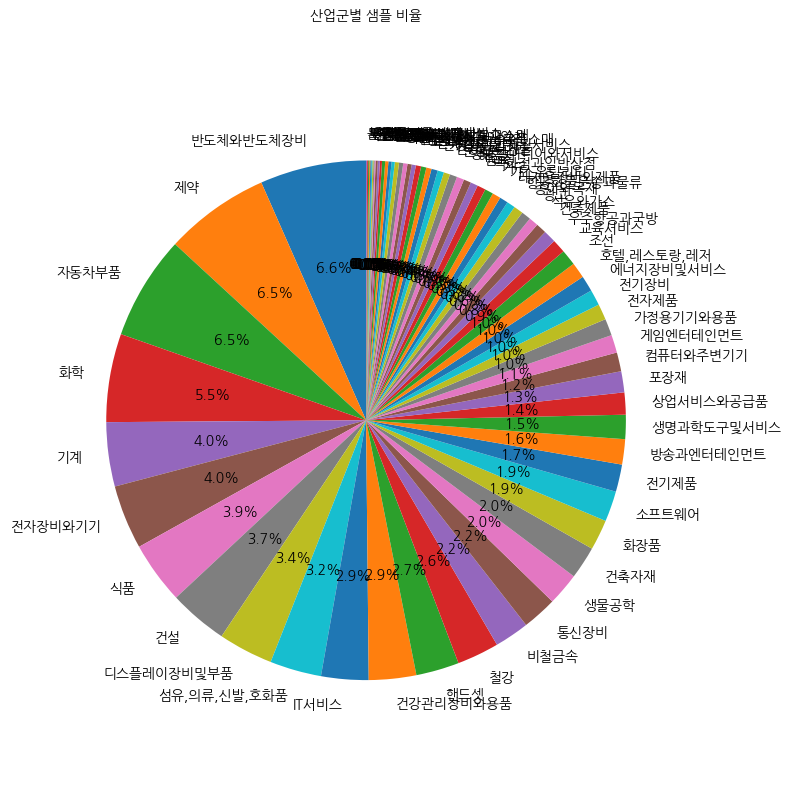

=== 산업군별 샘플 분포 (train_count / test_count / total_count) ===


,산업군,train_count,test_count,total_count
0,반도체와반도체장비,3636,1212,4848
1,제약,3600,1200,4800
2,자동차부품,3564,1188,4752
3,화학,3024,1008,4032
4,기계,2196,732,2928
...,...,...,...,...
70,은행,36,12,48
71,다각화된통신서비스,36,12,48
72,부동산,36,12,48
73,복합유틸리티,36,12,48


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# -------------------------------------------------------------
# 1) 반드시 본인 환경에 설치된 한글 폰트(.ttf 또는 .ttc)의 경로를 아래에 지정하세요.
#    예시(Windows) : r'C:\Windows\Fonts\malgun.ttf'
#    예시(macOS)   : '/Library/Fonts/AppleGothic.ttf'
#    예시(Linux)   : '/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc'
#    또는 사용자가 직접 받은 NanumGothic.ttf를 특정 폴더에 두고 경로 지정 가능
# -------------------------------------------------------------
font_path = '/Users/gun/Downloads/nanum-gothic/NanumGothic.ttf'  # ← 실제 경로로 바꿔 주세요!

if not os.path.isfile(font_path):
    raise FileNotFoundError(f"지정하신 한글 폰트 파일이 없습니다:\n{font_path}\n"
                            "경로를 다시 확인하거나, 시스템에 한글 폰트를 설치해주세요.")

# 2) Matplotlib에 한글 폰트 등록
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 축의 마이너스 기호가 깨지지 않도록

# -------------------------------------------------------------
# 3) 데이터 로드 (파일 경로를 본인 환경에 맞게 수정)
# -------------------------------------------------------------
# train_df = pd.read_csv('/mnt/data/train_stock_0.3.csv')
# test_df  = pd.read_csv('/mnt/data/test_stock_0.3.csv')

# -------------------------------------------------------------
# 4) '산업군'별 샘플 개수 집계
# -------------------------------------------------------------
# 4-1) train_df에서 산업군별 개수
industry_counts_train = train_df['산업군'].value_counts().reset_index()
industry_counts_train.columns = ['산업군', 'train_count']

# 4-2) test_df에서 산업군별 개수
industry_counts_test = test_df['산업군'].value_counts().reset_index()
industry_counts_test.columns = ['산업군', 'test_count']

# 4-3) train/test 합산하여 total_count 계산
industry_counts = pd.merge(
    industry_counts_train,
    industry_counts_test,
    on='산업군',
    how='outer'
).fillna(0)

industry_counts['train_count'] = industry_counts['train_count'].astype(int)
industry_counts['test_count']  = industry_counts['test_count'].astype(int)
industry_counts['total_count'] = industry_counts['train_count'] + industry_counts['test_count']

# 4-4) total_count 기준 내림차순 정렬
industry_counts_sorted = industry_counts.sort_values(by='total_count', ascending=False)

# -------------------------------------------------------------
# 5) 파이차트 (Pie) 그리기
# -------------------------------------------------------------
labels = industry_counts_sorted['산업군']
sizes  = industry_counts_sorted['total_count']

plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 10, 'fontproperties': font_prop}
)
plt.axis('equal')  # 파이차트를 원형으로 그리기
plt.title('산업군별 샘플 비율', fontsize=14, fontproperties=font_prop, y=1.05)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 6) 결과 테이블 출력
# -------------------------------------------------------------
print("=== 산업군별 샘플 분포 (train_count / test_count / total_count) ===")
display(industry_counts_sorted.reset_index(drop=True)) 

In [35]:
import pandas as pd

# -------------------------------------------------------------
# 1) 산업군별 Value 피처 요약 통계(평균, 중앙값, 표준편차, 1분위, 3분위) 테이블 생성
# -------------------------------------------------------------
value_feats = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
industries = train_df['산업군'].unique()

summary_list = []
for ind in industries:
    subset = train_df[train_df['산업군'] == ind]
    if subset.empty:
        continue
    
    stats = {'산업군': ind}
    for feat in value_feats:
        stats[f'{feat}_mean']   = subset[feat].mean()
        stats[f'{feat}_median'] = subset[feat].median()
        stats[f'{feat}_std']    = subset[feat].std()
        stats[f'{feat}_q1']     = subset[feat].quantile(0.25)
        stats[f'{feat}_q3']     = subset[feat].quantile(0.75)
    summary_list.append(stats)

summary_df = pd.DataFrame(summary_list).set_index('산업군')

# -------------------------------------------------------------
# 2) 요약 통계 테이블 출력
# -------------------------------------------------------------
display(summary_df)

,PER_mean,PER_median,PER_std,PER_q1,PER_q3,PBR_mean,PBR_median,PBR_std,PBR_q1,PBR_q3,PSR_mean,PSR_median,PSR_std,PSR_q1,PSR_q3,roe_per_ratio_mean,roe_per_ratio_median,roe_per_ratio_std,roe_per_ratio_q1,roe_per_ratio_q3
산업군,,,,,,,,,,,,,,,,,,,,
도로와철도운송,6.800041,5.428923,222.236460,-14.124228,22.249474,1.191963,0.730977,0.994515,0.605332,1.089221,2.113471,1.195489,2.706642,0.627890,2.282757,0.009990,0.003696,0.019231,0.000734,0.010971
반도체와반도체장비,5.539731,20.880808,674.142268,8.409243,46.225478,2.325076,1.896146,1.683279,1.283167,2.813041,6.426878,3.616408,8.540155,1.871097,7.456823,0.007582,0.002191,0.020213,0.000488,0.007556
디스플레이장비및부품,14.101832,14.529685,1233.832133,-8.618171,45.494549,2.582135,1.386697,6.368136,0.872045,2.365308,6.061218,3.379028,7.917853,1.577482,7.200540,0.023155,0.001790,0.121303,0.000257,0.008444
통신장비,15.221905,7.658071,574.630032,-33.903350,44.196188,3.667181,1.819540,7.518138,1.100924,3.366417,12.906795,5.476336,23.763623,2.559537,12.346270,0.022827,0.001220,0.176589,0.000180,0.006003
백화점과일반상점,62.108875,12.392263,721.123754,5.957061,21.059600,5.833916,0.406553,15.680102,0.308325,1.165850,37.257210,2.037940,135.079122,1.019760,4.833374,0.005923,0.002238,0.014709,0.000893,0.006081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
다각화된소비자서비스,39.024995,26.720698,36.361913,16.061655,45.188178,0.699314,0.680682,0.091943,0.615357,0.770741,4.379165,3.431515,2.731243,2.373173,5.346511,0.001561,0.001151,0.001413,0.000398,0.002420
부동산,-62.261470,-33.960173,210.264287,-84.062009,15.229785,1.611344,0.988626,1.216151,0.784540,2.097571,19.023814,14.033648,17.985427,4.876430,25.421916,0.001890,0.000216,0.003900,0.000089,0.000655
다각화된통신서비스,-52.768334,-31.250814,139.470999,-75.206475,18.638724,4.643189,4.874146,1.471459,3.141141,5.794305,16.281380,14.812963,11.575908,7.352803,21.588187,0.041007,0.001951,0.122472,0.000475,0.011845


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

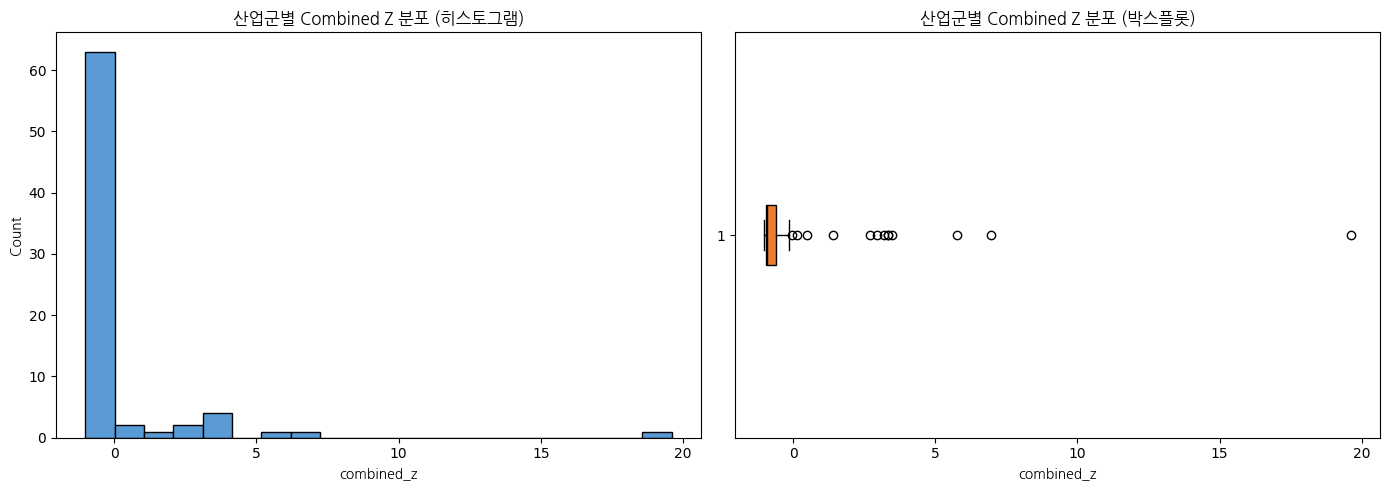

=== 임계값별 포함 산업군 개수 요약 ===


,Quantile,Cutoff (z값),Num_Industries
0,70%,-0.6931,23
1,75%,-0.5950,19
2,80%,-0.3821,15
3,85%,0.1185,12
4,90%,2.8536,8


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import zscore

# ------------------------------------------------------------
# 1) 한글 폰트 설정
#    → 본인 시스템에 설치된 한글 폰트(.ttf 또는 .ttc) 경로로 수정하세요.
# ------------------------------------------------------------
font_path = '/Users/gun/Downloads/nanum-gothic/NanumGothic.ttf'  # ← 실제 경로로 변경
if not os.path.isfile(font_path):
    raise FileNotFoundError(f"지정하신 한글 폰트 파일이 없습니다: {font_path}\n"
                            "경로를 다시 확인하거나 시스템에 한글 폰트를 설치해주세요.")

font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False


# ------------------------------------------------------------
# 2) 데이터 로드 (사전: train_df, test_df 존재 가정)
#    - train_df, test_df에는 반드시 아래 컬럼들이 포함되어 있어야 합니다:
#      ['산업군', 'PER', 'PBR', 'PSR', 'roe_per_ratio', ...]
# ------------------------------------------------------------
# 예시:
# train_df = pd.read_csv('/mnt/data/train_stock_0.3.csv')
# test_df  = pd.read_csv('/mnt/data/test_stock_0.3.csv')


# ------------------------------------------------------------
# 3) train/test 합치기
# ------------------------------------------------------------
full_df = pd.concat([train_df, test_df], ignore_index=True)


# ------------------------------------------------------------
# 4) 산업군별 Statistics 계산: Value 팩터들(표준편차)
# ------------------------------------------------------------
industry_stats = (
    full_df.groupby('산업군')[['PER', 'PBR', 'PSR', 'roe_per_ratio']]
           .agg(['std'])
)
# 컬럼 레이블 정리
industry_stats.columns = ['PER_std', 'PBR_std', 'PSR_std', 'roe_per_ratio_std']


# ------------------------------------------------------------
# 5) 산업군별 Z-Score 계산 (각 표준편차에 대하여)
# ------------------------------------------------------------
industry_stats['PER_z']           = zscore(industry_stats['PER_std'])
industry_stats['PBR_z']           = zscore(industry_stats['PBR_std'])
industry_stats['PSR_z']           = zscore(industry_stats['PSR_std'])
industry_stats['roe_per_ratio_z'] = zscore(industry_stats['roe_per_ratio_std'])

# 4개의 Z-Score를 합산하여 combined_z 생성
industry_stats['combined_z'] = (
    industry_stats['PER_z']
  + industry_stats['PBR_z']
  + industry_stats['PSR_z']
  + industry_stats['roe_per_ratio_z']
)


# ------------------------------------------------------------
# 6) Combined Z 분포 시각화
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (6-1) 히스토그램
axes[0].hist(industry_stats['combined_z'], bins=20, color='#5B9BD5', edgecolor='black')
axes[0].set_title('산업군별 Combined Z 분포 (히스토그램)',
                  fontproperties=font_prop, fontsize=12)
axes[0].set_xlabel('combined_z', fontproperties=font_prop)
axes[0].set_ylabel('Count',       fontproperties=font_prop)

# (6-2) 박스플롯
axes[1].boxplot(industry_stats['combined_z'], vert=False, patch_artist=True,
                boxprops=dict(facecolor='#ED7D31', color='black'),
                medianprops=dict(color='black'))
axes[1].set_title('산업군별 Combined Z 분포 (박스플롯)',
                  fontproperties=font_prop, fontsize=12)
axes[1].set_xlabel('combined_z', fontproperties=font_prop)

plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 7) 컷오프별 포함 산업군 개수 요약 테이블
# ------------------------------------------------------------
summary = pd.DataFrame({
    'Quantile':       [f"{int(q*100)}%" for q in quantiles],
    'Cutoff (z값)':   [round(val, 4) for val in q_values],
    'Num_Industries': [(industry_stats['combined_z'] > val).sum() for val in q_values]
})
print("=== 임계값별 포함 산업군 개수 요약 ===")
display(summary)

In [53]:
import pandas as pd

# -------------------------------------------------------------
# 0) 가정: 앞서 계산한 industry_stats_df, cutoff_80, high_variance_industries 가 이미 존재합니다.
#    - industry_stats_df: index='산업군', 칼럼에 'combined_z' 등이 있음
#    - cutoff_80: combined_z 상위 80% 컷오프 값
#    - high_variance_industries: combined_z > cutoff_80 인 산업군 리스트
#
# 1) train_df, test_df 역시 이미 로드되어 있으며, 
#    최소 아래 칼럼들이 존재한다고 가정합니다:
#    ['기준월','종목코드','회사명','산업군', … 기타 Value 피처 …]
# -------------------------------------------------------------

# (1) train/test를 합쳐서 편하게 ‘산업군 → 종목’ 매핑을 뽑을 수 있도록 합칩니다.
#     (만약 test에는 ‘산업군’만 있고, 종목코드/회사명의 중복 처리가 필요 없다면 train만 써도 무방합니다.)
all_df = pd.concat([train_df[['산업군','종목코드','회사명']],
                    test_df[['산업군','종목코드','회사명']]],
                   axis=0).drop_duplicates().reset_index(drop=True)

# (2) combined_z 상위 80% 컷오프를 이미 계산한 상태라고 가정합니다.
#     예를 들어 아래와 같이 high_variance_industries 리스트가 만들어져 있다고 칩시다.
#     → 실제 코드에서는 “ 앞서 제공된 코드” 를 돌려서 얻은 리스트를 사용하시면 됩니다.
#
#     예시) 
#     high_variance_industries = [
#         '가스유틸리티','건강관리업체및서비스','건강관리장비와용품', … 
#         '화장품'
#     ]

# -------------------------------------------------------------
# (3) “상위 80% 컷오프 초과” 산업군(high_variance_industries) 내 종목 리스트 출력
# -------------------------------------------------------------
print("▶ “고변동 산업군” 목록 (combined_z > 80% 컷오프):")
for ind in high_variance_industries:
    print(f"  - {ind}")
print()

# (4) 각 산업군에 속한 종목(종목코드/회사명)만 추려서, 
#     DataFrame 형태로 보기 좋게 정리해봅니다.
high_var_df = all_df[all_df['산업군'].isin(high_variance_industries)].copy()

# (4-1) 산업군별로 소속 종목 개수 집계
counts = high_var_df.groupby('산업군')['종목코드'].nunique().sort_values(ascending=False)
print("=== 고변동 산업군별 종목 개수 ===")
print(counts.to_frame(name='종목수').reset_index().to_string(index=False))
print("\n")

# (4-2) 산업군별 종목 리스트를 보기 쉽게 출력 (예: print, 혹은 tabular form)
#       화면에 너무 길게 출력되지 않도록, 각 산업군마다 “최대 10개까지만” 요약해서 보여주는 예시를 드립니다.
print("=== 고변동 산업군별 대표 종목(최대 10개까지) ===")
for ind in high_variance_industries:
    subset = high_var_df[high_var_df['산업군'] == ind][['종목코드','회사명']].drop_duplicates()
    # 종목 수가 많으면 10개까지만 샘플로 표시
    sample = subset.head(10).values.tolist()
    print(f"\n[{ind}] (총 {len(subset)}개 종목) → 예시 10개:")
    for code, name in sample:
        print(f"    • {code} / {name}")
print()

# -------------------------------------------------------------
# (5) “나머지 저변동 산업군” 목록도 함께 보고 싶다면 아래처럼 작성:
# -------------------------------------------------------------
all_industries = set(industry_stats_df.index.tolist())
low_variance_industries = sorted(all_industries - set(high_variance_industries))

print("▶ “저변동 산업군” 목록 (나머지):")
for ind in low_variance_industries:
    print(f"  - {ind}")
print()

# (6) 저변동 산업군에도 속한 종목 리스트를 보고 싶다면:
low_var_df = all_df[all_df['산업군'].isin(low_variance_industries)].copy()

# 예시) 저변동 산업군별 종목 개수
low_counts = low_var_df.groupby('산업군')['종목코드'].nunique().sort_values(ascending=False)
print("=== 저변동 산업군별 종목 개수 ===")
print(low_counts.to_frame(name='종목수').reset_index().to_string(index=False))
print()

# 예시) 저변동 산업군별 대표 종목 5개씩 출력
print("=== 저변동 산업군별 대표 종목(최대 5개까지) ===")
for ind in low_variance_industries:
    subset = low_var_df[low_var_df['산업군'] == ind][['종목코드','회사명']].drop_duplicates()
    sample = subset.head(5).values.tolist()
    print(f"\n[{ind}] (총 {len(subset)}개 종목) → 예시 5개:")
    for code, name in sample:
        print(f"    • {code} / {name}")
print()

▶ “고변동 산업군” 목록 (combined_z > 80% 컷오프):
  - 건강관리업체및서비스
  - 건강관리장비와용품
  - 건설
  - 게임엔터테인먼트
  - 디스플레이장비및부품
  - 상업서비스와공급품
  - 생명과학도구및서비스
  - 생물공학
  - 식품
  - 전자제품
  - 제약
  - 종이와목재
  - 항공사
  - 핸드셋
  - 화장품

=== 고변동 산업군별 종목 개수 ===
       산업군  종목수
        제약  100
        식품   59
        건설   56
디스플레이장비및부품   52
 건강관리장비와용품   45
       핸드셋   41
      생물공학   31
       화장품   29
생명과학도구및서비스   23
 상업서비스와공급품   21
  게임엔터테인먼트   17
      전자제품   15
     종이와목재    9
건강관리업체및서비스    6
       항공사    3


=== 고변동 산업군별 대표 종목(최대 10개까지) ===

[건강관리업체및서비스] (총 6개 종목) → 예시 10개:
    • 290660 / 네오펙트
    • 43710 / 서울리거
    • 226330 / 신테카바이오
    • 144510 / 지씨셀
    • 85660 / 차바이오텍
    • 214370 / 케어젠

[건강관리장비와용품] (총 45개 종목) → 예시 10개:
    • 28300 / HLB
    • 246960 / SCL사이언스
    • 138610 / 나이벡
    • 142280 / 녹십자엠에스
    • 214610 / 더바이오메드
    • 145720 / 덴티움
    • 263690 / 디알젬
    • 214680 / 디알텍
    • 39840 / 디오
    • 228670 / 레이

[건설] (총 56개 종목) → 예시 10개:
    • 6360 / GS건설
    • 12630 / HDC
    • 39570 / HDC랩스
    • 294870 / HDC현대산

In [59]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# -------------------------------------------------------------
# 0) 가정: train_df, test_df가 이미 로드되어 있으며, 다음 컬럼이 존재합니다.
#    - train_df: ['기준월','종목코드','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률','산업군', ...]
#    - test_df:  ['기준월','종목코드','회사명','PER','PBR','PSR','roe_per_ratio','3개월수익률','산업군', ...]
# -------------------------------------------------------------

# 1) 변수 정의
value_feats  = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
industry_col = '산업군'
target_col   = '3개월수익률'

# 2) train_df 복사 및 글로벌 Percentile Rank 계산
train_df = train_df.copy()
train_df['return_prank'] = train_df[target_col].rank(pct=True)

test_df = test_df.copy()  # 필요하면 test_df에도 3개월수익률이 있을 수 있음

# -------------------------------------------------------------
# 3) 산업군별 value_feats 표준편차 → z-score → 합산(= combined_z)
# -------------------------------------------------------------
industry_stats = (
    train_df
    .groupby(industry_col)[value_feats]
    .std()
    .rename(columns=lambda x: f'{x}_std')
    .reset_index()
)

for col in [f'{f}_std' for f in value_feats]:
    μ = industry_stats[col].mean()
    σ = industry_stats[col].std(ddof=0)
    industry_stats[f'{col}_z'] = (industry_stats[col] - μ) / (σ + 1e-8)

z_cols = [f'{f}_std_z' for f in value_feats]
industry_stats['combined_z'] = industry_stats[z_cols].sum(axis=1)

# -------------------------------------------------------------
# 4) 상위 80% 컷오프 → 고변동(High‐Vol) vs 저변동(Low‐Vol) 산업군 분리
# -------------------------------------------------------------
cutoff_85 = industry_stats['combined_z'].quantile(0.85)
high_vol_industries = industry_stats.loc[industry_stats['combined_z'] > cutoff_85, industry_col].tolist()
low_vol_industries  = industry_stats.loc[industry_stats['combined_z'] <= cutoff_85, industry_col].tolist()

print(f">>> combined_z 85% 컷오프: {cutoff_85:.4f}")
print(">>> 고변동 산업군 목록 (상위 20%):")
for ind in high_vol_industries:
    cz = industry_stats.loc[industry_stats[industry_col] == ind, 'combined_z'].values[0]
    print(f" - {ind} (combined_z = {cz:.4f})")

# -------------------------------------------------------------
# 5) Train/Test를 고/저변동 산업군으로 분리
# -------------------------------------------------------------
train_high = train_df[train_df[industry_col].isin(high_vol_industries)].reset_index(drop=True)
train_low  = train_df[train_df[industry_col].isin(low_vol_industries)].reset_index(drop=True)

test_high  = test_df[test_df[industry_col].isin(high_vol_industries)].reset_index(drop=True)
test_low   = test_df[test_df[industry_col].isin(low_vol_industries)].reset_index(drop=True)

# -------------------------------------------------------------
# 6) 저변동 산업군(Low‐Vol) 모델: 
#    Industry‐Neutralized Percentile → RF
# -------------------------------------------------------------
# 6.1) train_low에서 각 value_feat를 산업군 내부 퍼센타일 랭크로 변환
for feat in value_feats:
    train_low[f'{feat}_ind_prank'] = train_low.groupby(industry_col)[feat].rank(pct=True)

# 6.2) test_low에서도 동일하게 산업군 내부 퍼센타일 랭크 계산
for feat in value_feats:
    test_low[f'{feat}_ind_prank'] = test_low.groupby(industry_col)[feat].rank(pct=True)

low_feat_cols = [f'{feat}_ind_prank' for feat in value_feats]
X_low = train_low[low_feat_cols].fillna(0)
y_low = train_low['return_prank']

low_vol_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])
low_vol_pipe.fit(X_low, y_low)

# 6.3) test_low 예측
X_low_test = test_low[low_feat_cols].fillna(0)
test_low['pred_return_prank'] = low_vol_pipe.predict(X_low_test)

# -------------------------------------------------------------
# 7) 고변동 산업군(High‐Vol) 모델: 
#    Two‐Step (Value Standardize → KMeans → Cluster별 RF)
# -------------------------------------------------------------
# 7.1) train_high의 value_feats 표준화
scaler_val_high = StandardScaler().fit(train_high[value_feats].fillna(0))
X_val_high = scaler_val_high.transform(train_high[value_feats].fillna(0))

# 7.2) 실루엣 점수로 최적 k 탐색 (k=2~6)
sil_scores = []
k_candidates = range(2, 7)
for k in k_candidates:
    labels_tmp = KMeans(n_clusters=k, random_state=42).fit_predict(X_val_high)
    sil_scores.append(silhouette_score(X_val_high, labels_tmp))

best_k = k_candidates[np.argmax(sil_scores)]
print(f">>> 고변동 산업군 전용 KMeans Optimal k: {best_k}")

# 7.3) 최적 k로 KMeans 학습 → train_high에 클러스터 라벨 부여
kmeans_high = KMeans(n_clusters=best_k, random_state=42)
train_high['vol_cluster'] = kmeans_high.fit_predict(X_val_high)

# 7.4) test_high에도 스케일러+KMeans 적용 → 클러스터 라벨 생성
X_val_high_test = scaler_val_high.transform(test_high[value_feats].fillna(0))
test_high['vol_cluster'] = kmeans_high.predict(X_val_high_test)

# 7.5) 클러스터별 RF 학습 & 예측
cluster_models = {}
test_high['pred_return_prank'] = np.nan

for c in range(best_k):
    # (1) 해당 클러스터의 train subset
    sub = train_high[train_high['vol_cluster'] == c].reset_index(drop=True)
    X_sub = sub[value_feats].fillna(0)
    y_sub = sub['return_prank']
    
    # (2) 클러스터별 RF 학습
    pipe_c = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ])
    pipe_c.fit(X_sub, y_sub)
    cluster_models[c] = pipe_c
    
    # (3) 해당 클러스터의 test subset 인덱스
    idxs = test_high[test_high['vol_cluster'] == c].index
    if len(idxs) == 0:
        # 테스트 샘플이 하나도 없으면 건너뜁니다.
        continue
    
    X_test_c = test_high.loc[idxs, value_feats].fillna(0)
    test_high.loc[idxs, 'pred_return_prank'] = pipe_c.predict(X_test_c)

# -------------------------------------------------------------
# 8) 전체 test_df에 예측값 합치기
# -------------------------------------------------------------
test_df = test_df.copy()
test_df['pred_return_prank'] = np.nan

# 8.1) 고변동 산업군 예측값 복사
high_idx = test_df[industry_col].isin(high_vol_industries)
test_df.loc[high_idx, 'pred_return_prank'] = test_high['pred_return_prank'].values

# 8.2) 저변동 산업군 예측값 복사
low_idx = test_df[industry_col].isin(low_vol_industries)
test_df.loc[low_idx, 'pred_return_prank'] = test_low['pred_return_prank'].values

# -------------------------------------------------------------
# 9) (선택) 최종 성능 평가 예시: Top20 실제 3개월수익률 통계
# -------------------------------------------------------------
def evaluate_top20(df, pred_col):
    top20 = df.sort_values(by=pred_col, ascending=False).head(20)
    rets = top20[target_col].dropna()
    return {
        'mean_return_%':   rets.mean(),
        'median_return_%': rets.median(),
        'std_return_%':    rets.std(),
        'win_rate':       float((rets > 0).mean())
    }

if target_col in test_df.columns:
    res_high = evaluate_top20(test_high, 'pred_return_prank')
    res_low  = evaluate_top20(test_low,  'pred_return_prank')
    res_all  = evaluate_top20(test_df,   'pred_return_prank')
    
    print("\n=== 고변동 산업군 (Two‐Step) Top20 성능 ===")
    print(res_high)
    print("\n=== 저변동 산업군 (Ind‐Neu Percentile→RF) Top20 성능 ===")
    print(res_low)
    print("\n=== 전체 통합 Top20 성능 ===")
    print(res_all)

>>> combined_z 85% 컷오프: -0.3914
>>> 고변동 산업군 목록 (상위 20%):
 - 건강관리업체및서비스 (combined_z = 5.3299)
 - 건강관리장비와용품 (combined_z = 1.7549)
 - 게임엔터테인먼트 (combined_z = 2.9752)
 - 생명과학도구및서비스 (combined_z = 19.0709)
 - 생물공학 (combined_z = -0.1409)
 - 전자제품 (combined_z = 3.3380)
 - 제약 (combined_z = 3.5709)
 - 종이와목재 (combined_z = 0.0940)
 - 판매업체 (combined_z = -0.3909)
 - 항공사 (combined_z = 8.1666)
 - 핸드셋 (combined_z = 3.9580)
 - 화장품 (combined_z = 2.0734)
>>> 고변동 산업군 전용 KMeans Optimal k: 2

=== 고변동 산업군 (Two‐Step) Top20 성능 ===
{'mean_return_%': np.float64(0.0891736325), 'median_return_%': np.float64(0.021834288), 'std_return_%': np.float64(0.4385766737749259), 'win_rate': 0.6}

=== 저변동 산업군 (Ind‐Neu Percentile→RF) Top20 성능 ===
{'mean_return_%': np.float64(0.04301244080000001), 'median_return_%': np.float64(0.0417529145), 'std_return_%': np.float64(0.20822184195876187), 'win_rate': 0.65}

=== 전체 통합 Top20 성능 ===
{'mean_return_%': np.float64(0.06739100880000001), 'median_return_%': np.float64(0.049591740499999995

In [65]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 (본인의 경로에 맞게 수정)
# ───────────────────────────────────────────────────────────────────
train_df = pd.read_csv('/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv', parse_dates=['기준월'])
test_df  = pd.read_csv('/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv',  parse_dates=['기준월'])

# ───────────────────────────────────────────────────────────────────
# 2) 사용할 컬럼 정의
# ───────────────────────────────────────────────────────────────────
value_feats  = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
target_col   = '3개월수익률'
date_col     = '기준월'

# ───────────────────────────────────────────────────────────────────
# 3) 결측치 처리: 가치 지표들에 대해 결측치는 0으로 대체
#    (원한다면 다른 방법으로 바꾸셔도 됩니다)
# ───────────────────────────────────────────────────────────────────
train_df[value_feats] = train_df[value_feats].fillna(0)
test_df [value_feats] = test_df [value_feats].fillna(0)

# ───────────────────────────────────────────────────────────────────
# 4) 2021~2023 학습, 2024 테스트 가정 → 이미 train_df/test_df로 나뉘어 있으므로 생략
#    (만약 하나의 파일에 2021~2024가 모두 들어있다면, 아래처럼 연도별로 나누어 주세요)
# 
# df = pd.read_csv('all_data.csv', parse_dates=['기준월'])
# train_df = df[df['기준월'].dt.year.isin([2021,2022,2023])].copy()
# test_df  = df[df['기준월'].dt.year == 2024].copy()
# ───────────────────────────────────────────────────────────────────

print(f"학습용 데이터: {train_df.shape} (기간: {train_df[date_col].min().date()} ~ {train_df[date_col].max().date()})")
print(f"테스트용 데이터: {test_df.shape} (기간: {test_df[date_col].min().date()} ~ {test_df[date_col].max().date()})")

학습용 데이터: (55044, 36) (기간: 2021-01-01 ~ 2023-12-01)
테스트용 데이터: (18348, 36) (기간: 2024-01-01 ~ 2024-12-01)


In [70]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 (본인 경로에 맞게 수정하세요)
# ───────────────────────────────────────────────────────────────────
# 예: train_df 에는 2021-01-01 ~ 2023-12-01 까지, test_df 에는 2024-01-01 ~ 2024-12-01 까지의 데이터가 있다고 가정
train_df = pd.read_csv('/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv',
                       parse_dates=['기준월'])
test_df  = pd.read_csv('/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv',
                       parse_dates=['기준월'])

# ───────────────────────────────────────────────────────────────────
# 2) 컬럼 정의
# ───────────────────────────────────────────────────────────────────
value_feats = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
target_col  = '3개월수익률'
date_col    = '기준월'

# ───────────────────────────────────────────────────────────────────
# 3) 결측치 처리: 가치 지표에서 NaN은 0으로 대체
# ───────────────────────────────────────────────────────────────────
train_df[value_feats] = train_df[value_feats].fillna(0)
test_df [value_feats] = test_df [value_feats].fillna(0)

# ───────────────────────────────────────────────────────────────────
# 4) Z-Score 계산 (2021~2023 학습 데이터로 fit → 2024에도 동일하게 transform)
# ───────────────────────────────────────────────────────────────────
scaler_value = StandardScaler().fit(train_df[value_feats])

# 4-1) train_df 한꺼번에 transform → 배열 형태(행 수 × 4)
scaled_train = scaler_value.transform(train_df[value_feats])
# 4-2) test_df 한꺼번에 transform → 배열 형태(행 수 × 4)
scaled_test  = scaler_value.transform(test_df [value_feats])

# 4-3) Z-Score 결과를 새로운 컬럼으로 저장
z_cols = [feat + '_z' for feat in value_feats]  # ['PER_z','PBR_z','PSR_z','roe_per_ratio_z']
train_df[z_cols] = scaled_train
test_df [z_cols] = scaled_test

# ───────────────────────────────────────────────────────────────────
# 5) Composite Z-Score 생성: 4개 Z-Score를 단순 평균으로 묶기
# ───────────────────────────────────────────────────────────────────
train_df['composite_z'] = train_df[z_cols].mean(axis=1)
test_df ['composite_z'] = test_df [z_cols].mean(axis=1)

# ───────────────────────────────────────────────────────────────────
# 6) Composite Z-Score 기준 Top20 성과 계산 함수
# ───────────────────────────────────────────────────────────────────
def evaluate_top20_from_score(df, score_col):
    """
    score_col 컬럼 기준 내림차순으로 상위 20개 종목을 뽑아,
    실제 target_col(3개월수익률) 성과(평균, 중간, 표준편차, 승률)를 리턴.
    """
    top20 = df.sort_values(by=score_col, ascending=False).head(20)
    rets  = top20[target_col]
    return {
        'mean_return_%':   rets.mean(),
        'median_return_%': rets.median(),
        'std_return_%':    rets.std(),
        'win_rate':       float((rets > 0).mean())
    }

# 6-1) 2024년 test_df 에서 composite_z 기준 Top20 성과 확인
composite_results = evaluate_top20_from_score(test_df, 'composite_z')
print("=== [베이스라인1] Composite Z-Score Top20 성능 (2024) ===")
print(composite_results)

# ───────────────────────────────────────────────────────────────────
# 7) KNN Regression 베이스라인 (네 개 Z-Score → 3개월수익률 예측 → Top20)
# ───────────────────────────────────────────────────────────────────
# 7-1) train_knn, test_knn에는 target이 NaN인 경우(수익률이 없는 경우) 제거
train_knn = train_df.dropna(subset=[target_col]).copy()
test_knn  = test_df .dropna(subset=[target_col]).copy()

# 7-2) X,y 정의 (X는 4개 Z-Score, y는 3개월수익률)
X_train_knn = train_knn[z_cols]
y_train_knn = train_knn[target_col]

X_test_knn = test_knn[z_cols]
y_test_knn = test_knn[target_col]  # 실제 성과 비교를 위해

# 7-3) KNN Regressor 학습 → 예측
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

test_knn['pred_knn'] = knn.predict(X_test_knn)

# 7-4) pred_knn 순위 상위 20개 성과 확인
knn_results = evaluate_top20_from_score(test_knn, 'pred_knn')
print("\n=== [베이스라인2] KNN Regressor Top20 성능 (2024) ===")
print(knn_results)

=== [베이스라인1] Composite Z-Score Top20 성능 (2024) ===
{'mean_return_%': np.float64(-0.14246288155000003), 'median_return_%': np.float64(-0.190964915), 'std_return_%': np.float64(0.3757404453054152), 'win_rate': 0.15}

=== [베이스라인2] KNN Regressor Top20 성능 (2024) ===
{'mean_return_%': np.float64(0.21040990495000003), 'median_return_%': np.float64(0.0860249315), 'std_return_%': np.float64(0.6495655116939852), 'win_rate': 0.6}


In [72]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 및 전처리
# ───────────────────────────────────────────────────────────────────
train_df = pd.read_csv('/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv',
                       parse_dates=['기준월'])
test_df  = pd.read_csv('/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv',
                       parse_dates=['기준월'])

value_feats = ['PER', 'PBR', 'PSR', 'roe_per_ratio']
target_col  = '3개월수익률'

# 결측치는 0으로 대체
train_df[value_feats] = train_df[value_feats].fillna(0)
test_df [value_feats] = test_df [value_feats].fillna(0)

# 연도(2021~2023 = train / 2024 = test)로 분리(필요 시)
train_df = train_df[train_df['기준월'].dt.year < 2024].reset_index(drop=True)
test_df  = test_df [test_df ['기준월'].dt.year == 2024].reset_index(drop=True)

# ───────────────────────────────────────────────────────────────────
# 2) Z-Score 계산 (네 개 가치 지표)
# ───────────────────────────────────────────────────────────────────
scaler_value = StandardScaler().fit(train_df[value_feats])
train_z = scaler_value.transform(train_df[value_feats])
test_z  = scaler_value.transform(test_df [value_feats])

z_cols = [feat + '_z' for feat in value_feats]
train_df[z_cols] = train_z
test_df [z_cols] = test_z

# Composite Z-Score
train_df['composite_z'] = train_df[z_cols].mean(axis=1)
test_df ['composite_z'] = test_df [z_cols].mean(axis=1)

# ───────────────────────────────────────────────────────────────────
# 3) Industry-Neutralized Percentile for RF-only
# ───────────────────────────────────────────────────────────────────
train_df['value_pct_ind'] = train_df.groupby('산업군')[target_col].rank(pct=True)
test_df ['value_pct_ind'] = test_df.groupby('산업군')[target_col].rank(pct=True)

# ───────────────────────────────────────────────────────────────────
# 4) “모델별 예측값”을 담을 빈 컬럼 생성
# ───────────────────────────────────────────────────────────────────
test_df['pred_composite'] = np.nan
test_df['pred_knn']      = np.nan
test_df['pred_rf_ind']   = np.nan
test_df['pred_two_step'] = np.nan

# ───────────────────────────────────────────────────────────────────
# 5) ① Composite Z 기준 Top20 선별 성과
# ───────────────────────────────────────────────────────────────────
# (실제로 예측 모델이 아니라, 이미 계산된 composite_z로 바로 점수 사용)
test_df['pred_composite'] = test_df['composite_z']

# ───────────────────────────────────────────────────────────────────
# 6) ② KNN Regressor (Z만 입력 → 3개월수익률 예측)
# ───────────────────────────────────────────────────────────────────
# (6-1) train_knn / test_knn 에서 target 결측행 제거
train_knn = train_df.dropna(subset=[target_col]).copy()
test_knn  = test_df .dropna(subset=[target_col]).copy()

X_train_knn = train_knn[z_cols]
y_train_knn = train_knn[target_col]

X_test_knn  = test_knn[z_cols]
knn         = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

test_df.loc[test_knn.index, 'pred_knn'] = knn.predict(X_test_knn)

# ───────────────────────────────────────────────────────────────────
# 7) ③ RF-only (산업 중립 Percentile → RF)
# ───────────────────────────────────────────────────────────────────
# (7-1) train_rf / test_rf 에서 target 결측행 제거
train_rf = train_df.dropna(subset=[target_col]).copy()
test_rf  = test_df .dropna(subset=[target_col]).copy()

X_train_rf = train_rf[['value_pct_ind']].fillna(0)
y_train_rf = train_rf['value_pct_ind']

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf',     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])
rf_pipe.fit(X_train_rf, y_train_rf)

test_df.loc[test_rf.index, 'pred_rf_ind'] = rf_pipe.predict(test_rf[['value_pct_ind']].fillna(0))

# ───────────────────────────────────────────────────────────────────
# 8) ④ Two-Step (고변동 산업군만 KMeans → RF)
# ───────────────────────────────────────────────────────────────────
# (8-1) 먼저 산업별 통계(Std) 계산 → combined_z → 고변동군 추출 (85% 컷오프)
#       → industry_stats_df는 사전에 만들어 두었다고 가정
cutoff_85 = industry_stats_df['combined_z'].quantile(0.85)
high_vol_industries = industry_stats_df.index[ industry_stats_df['combined_z'] > cutoff_85 ].tolist()

# (8-2) train_high / test_high 분리
train_high = train_df[ train_df['산업군'].isin(high_vol_industries) ].copy()
test_high  = test_df [ test_df ['산업군'].isin(high_vol_industries) ].copy()

# (8-3) Value-only KMeans (k=2) → 클러스터링
value_data_high = train_high[value_feats].fillna(0).values
kmeans_high     = KMeans(n_clusters=2, random_state=42).fit(value_data_high)

train_high['vol_cluster'] = kmeans_high.predict(value_data_high)
test_high ['vol_cluster'] = kmeans_high.predict(test_high[value_feats].fillna(0).values)

# (8-4) train_high 내 ‘value_prank’ 전체 Percentile 생성
train_high['value_prank'] = train_high[target_col].rank(pct=True)

# (8-5) 클러스터별 RF 학습 → test_high 예측
cluster_models = {}
test_high['pred_two_step'] = np.nan

for c in train_high['vol_cluster'].unique():
    sub = train_high[train_high['vol_cluster'] == c]
    Xc  = sub[value_feats].fillna(0)
    yc  = sub['value_prank']

    pipe_c = Pipeline([
        ('scaler', StandardScaler()),
        ('rf',     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ])
    pipe_c.fit(Xc, yc)
    cluster_models[c] = pipe_c

    idxs    = test_high[test_high['vol_cluster'] == c].index
    Xc_test = test_high.loc[idxs, value_feats].fillna(0)
    test_high.loc[idxs, 'pred_two_step'] = pipe_c.predict(Xc_test)

# (8-6) test_df 전체에 pred_two_step 칼럼 채우기 (저변동군은 NaN으로 남게 됨)
test_df.loc[test_high.index, 'pred_two_step'] = test_high['pred_two_step']

# ───────────────────────────────────────────────────────────────────
# 9) 네 개 모델의 Top20 성과 비교 함수
# ───────────────────────────────────────────────────────────────────
def evaluate_top20(df, score_col):
    top20 = df.sort_values(by=score_col, ascending=False).head(20)
    rets  = top20[target_col]
    return {
        'mean_return_%':   rets.mean(),
        'median_return_%': rets.median(),
        'std_return_%':    rets.std(),
        'win_rate':       float((rets > 0).mean())
    }

# 9-1) Composite Z
res_composite = evaluate_top20(test_df, 'pred_composite')

# 9-2) KNN
res_knn = evaluate_top20(test_df, 'pred_knn')

# 9-3) RF-only (산업 중립 Percentile → RF)
res_rf_ind = evaluate_top20(test_df, 'pred_rf_ind')

# 9-4) Two-Step (고변동군 KMeans → RF)
res_two_step = evaluate_top20(test_df, 'pred_two_step')

print("=== 모델별 Top20 성과 비교 (2024) ===")
print("1) Composite Z-Score       :", res_composite)
print("2) KNN Regressor          :", res_knn)
print("3) RF only (산업 중립)     :", res_rf_ind)
print("4) Two-Step (고변동군 KMeans→RF) :", res_two_step)

=== 모델별 Top20 성과 비교 (2024) ===
1) Composite Z-Score       : {'mean_return_%': np.float64(-0.14246288155000003), 'median_return_%': np.float64(-0.190964915), 'std_return_%': np.float64(0.3757404453054152), 'win_rate': 0.15}
2) KNN Regressor          : {'mean_return_%': np.float64(0.21040990495000003), 'median_return_%': np.float64(0.0860249315), 'std_return_%': np.float64(0.6495655116939852), 'win_rate': 0.6}
3) RF only (산업 중립)     : {'mean_return_%': np.float64(0.9823198988999999), 'median_return_%': np.float64(0.896631255), 'std_return_%': np.float64(0.756167193798262), 'win_rate': 0.95}
4) Two-Step (고변동군 KMeans→RF) : {'mean_return_%': np.float64(0.08491989265000001), 'median_return_%': np.float64(0.021834288), 'std_return_%': np.float64(0.43998230434456526), 'win_rate': 0.6}


In [77]:
pip install ace_tools

116332.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ----------------------------------------
# 0) 한글 폰트 설정 (예: NanumGothic)
# ----------------------------------------
font_path = '/Users/gun/Downloads/nanum-gothic/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False

# ----------------------------------------
# I) 데이터 로드 및 전처리
#   - train_df: 2021~2023 데이터
#   - test_df : 2024 데이터 (필요 시 참고)
# ----------------------------------------
train_df = pd.read_csv('/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv')
test_df  = pd.read_csv('/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv')

train_df['기준월'] = pd.to_datetime(train_df['기준월'])
test_df ['기준월'] = pd.to_datetime(test_df ['기준월'])

# 전체 데이터를 합쳐놓고, 리밸런싱 시점마다 (train←full_df<rebalance_date, screen←full_df==rebalance_date)로 나눴습니다.
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

value_feats  = ['PER','PBR','PSR','roe_per_ratio']
industry_col = '산업군'
target_col   = '3개월수익률'
date_col     = '기준월'

# ----------------------------------------
# II) 백테스트 설정
#   - 기간: 2021-01-01 ~ 2023-12-01
#   - 매월 첫날 리밸런싱, 상위 20개 포트폴리오 구성
# ----------------------------------------
backtest_records = []
rebalance_dates = pd.date_range(start='2021-01-01', end='2023-12-01', freq='MS')

for rebalance_date in rebalance_dates:
    # (1) 과거 학습용: 기준월 < rebalance_date
    train_data  = full_df[full_df[date_col] < rebalance_date].copy()
    # (2) 스크리닝시점: 기준월 == rebalance_date
    screen_data = full_df[full_df[date_col] == rebalance_date].copy()
    if screen_data.empty or len(train_data) < 100:
        continue

    # ───────────────────────────────────────────────────────────────────
    # A) RF-only (Industry-Neutralized Percentile → RF)
    # ───────────────────────────────────────────────────────────────────
    train_data['value_pct_ind'] = train_data.groupby(industry_col)[target_col].rank(pct=True)

    rf_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('rf',     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
    ])
    X_rf_train = train_data[['value_pct_ind']].fillna(0)
    y_rf_train = train_data['value_pct_ind']
    rf_pipe.fit(X_rf_train, y_rf_train)

    screen_data['value_pct_ind'] = screen_data.groupby(industry_col)[target_col].rank(pct=True)
    screen_data['pred_rf'] = rf_pipe.predict(screen_data[['value_pct_ind']].fillna(0))

    # ───────────────────────────────────────────────────────────────────
    # B) Two-Step (고변동군: Value-only KMeans → RF, 저변동군은 RF-only)
    # ───────────────────────────────────────────────────────────────────
    # (B1) 업종별 Value(4개) 표준편차
    industry_stats = train_data.groupby(industry_col)[value_feats].std().add_suffix('_std')

    # (B2) 4개 표준편차를 Z-스코어로 표준화 후 합산 → combined_z
    std_cols = ['PER_std','PBR_std','PSR_std','roe_per_ratio_std']
    tmp = industry_stats[std_cols]
    tmp_z = (tmp - tmp.mean()) / tmp.std()
    industry_stats['combined_z'] = tmp_z.sum(axis=1)

    # (B3) 상위 80% 컷오프로 “고변동업종” 리스트
    cutoff_80 = industry_stats['combined_z'].quantile(0.80)
    high_vol_industries = industry_stats[industry_stats['combined_z'] > cutoff_80].index.tolist()

    # (B4) train_data, screen_data를 고/저변동으로 분리
    train_high = train_data[train_data[industry_col].isin(high_vol_industries)].copy()
    train_low  = train_data[~train_data[industry_col].isin(high_vol_industries)].copy()
    screen_high = screen_data[screen_data[industry_col].isin(high_vol_industries)].copy()
    screen_low  = screen_data[~screen_data[industry_col].isin(high_vol_industries)].copy()

    # (B5) 고변동군: Value-only KMeans(k=2)
    if not train_high.empty:
        X_high = train_high[value_feats].fillna(0).values
        kmeans_high = KMeans(n_clusters=2, random_state=42).fit(X_high)
        train_high['vol_cluster'] = kmeans_high.predict(X_high)
        screen_high['vol_cluster'] = kmeans_high.predict(screen_high[value_feats].fillna(0).values)

        # (B6) train_high에서 전체 순위 value_prank 계산
        train_high['value_prank'] = train_high[target_col].rank(pct=True)

        # (B7) 각 클러스터별 RF 모델 학습 및 screen_high 예측
        screen_high['pred_two_step'] = np.nan
        cluster_models = {}

        for c in train_high['vol_cluster'].unique():
            sub = train_high[train_high['vol_cluster'] == c]
            Xc  = sub[value_feats].fillna(0)
            yc  = sub['value_prank']

            pipe_c = Pipeline([
                ('scaler', StandardScaler()),
                ('rf',     RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
            ])
            pipe_c.fit(Xc, yc)
            cluster_models[c] = pipe_c

            # “스키머링 데이터 screen_high” 중 해당 클러스터에 속한 인덱스만 뽑아서 예측
            idxs = screen_high[screen_high['vol_cluster'] == c].index
            if len(idxs) > 0:
                Xc_test = screen_high.loc[idxs, value_feats].fillna(0)
                screen_high.loc[idxs, 'pred_two_step'] = pipe_c.predict(Xc_test)
            # idxs가 비어 있으면 predict 호출을 건너뛰고 NaN 그대로 둠

    else:
        # train_high가 비어 있으면, screen_high 전체 pred_two_step도 NaN
        screen_high['pred_two_step'] = np.nan

    # (B8) 저변동군은 RF-only 점수(pred_rf)를 그대로 사용
    screen_low['pred_two_step'] = screen_low['pred_rf']

    # (B9) screen_data에 두 단계 점수 합치기
    # ※ 여기서는 인덱스를 그대로 쓰므로 concat→정렬 없이 바로 병합해도 됩니다
    screen_data['pred_twostep'] = pd.concat([
        screen_high['pred_two_step'],
        screen_low['pred_two_step']
    ])

    # ───────────────────────────────────────────────────────────────────
    # C) KNN Regressor (Value Z-스코어 → 3M 수익률 예측)
    # ───────────────────────────────────────────────────────────────────
    scaler_val = StandardScaler().fit(train_data[value_feats].fillna(0))
    train_val_z = pd.DataFrame(
        scaler_val.transform(train_data[value_feats].fillna(0)),
        columns=[f + '_z' for f in value_feats],
        index=train_data.index
    )
    train_data = pd.concat([train_data, train_val_z], axis=1)

    knn = KNeighborsRegressor(n_neighbors=20, weights='distance')
    X_knn_train = train_data[[f + '_z' for f in value_feats]].fillna(0)
    y_knn_train = train_data[target_col]
    knn.fit(X_knn_train, y_knn_train)

    screen_val_z = pd.DataFrame(
        scaler_val.transform(screen_data[value_feats].fillna(0)),
        columns=[f + '_z' for f in value_feats],
        index=screen_data.index
    )
    screen_data = pd.concat([screen_data, screen_val_z], axis=1)
    screen_data['pred_knn'] = knn.predict(screen_data[[f + '_z' for f in value_feats]].fillna(0))

    # ───────────────────────────────────────────────────────────────────
    # D) Composite Z-Score (4개 Z-스코어 평균)
    # ───────────────────────────────────────────────────────────────────
    screen_data['composite_z'] = screen_data[[f + '_z' for f in value_feats]].mean(axis=1)

    # ───────────────────────────────────────────────────────────────────
    # E) 상위 20개 종목 선택 및 기록
    # ───────────────────────────────────────────────────────────────────
    candidates = screen_data.copy()
    candidates['리밸런싱_날짜'] = rebalance_date

    # E1) RF-only Top20
    top20_rf = candidates.nlargest(20, 'pred_rf')
    for idx, row in top20_rf.iterrows():
        backtest_records.append({
            '리밸런싱_날짜': rebalance_date,
            '모델': 'RF-only',
            '종목코드': row['종목코드'],
            '예측스코어': row['pred_rf'],
            '실제_3M_수익률': row[target_col]
        })

    # E2) Two-Step Top20
    top20_ts = candidates.nlargest(20, 'pred_twostep')
    for idx, row in top20_ts.iterrows():
        backtest_records.append({
            '리밸런싱_날짜': rebalance_date,
            '모델': 'Two-Step',
            '종목코드': row['종목코드'],
            '예측스코어': row['pred_twostep'],
            '실제_3M_수익률': row[target_col]
        })

    # E3) KNN Top20
    top20_knn = candidates.nlargest(20, 'pred_knn')
    for idx, row in top20_knn.iterrows():
        backtest_records.append({
            '리밸런싱_날짜': rebalance_date,
            '모델': 'KNN',
            '종목코드': row['종목코드'],
            '예측스코어': row['pred_knn'],
            '실제_3M_수익률': row[target_col]
        })

    # E4) Composite Z Top20
    top20_cz = candidates.nlargest(20, 'composite_z')
    for idx, row in top20_cz.iterrows():
        backtest_records.append({
            '리밸런싱_날짜': rebalance_date,
            '모델': 'Composite Z',
            '종목코드': row['종목코드'],
            '예측스코어': row['composite_z'],
            '실제_3M_수익률': row[target_col]
        })

# ───────────────────────────────────────────────────────────────────
# III) 백테스트 결과 집계
# ───────────────────────────────────────────────────────────────────
bt_df = pd.DataFrame(backtest_records)

# 1) (리밸런싱_날짜, 모델)별 상위 20개 종목 실제 3M 수익률 평균 → '기간수익'
monthly_returns = (
    bt_df
      .groupby(['리밸런싱_날짜','모델'])['실제_3M_수익률']
      .mean()
      .reset_index()
      .rename(columns={'실제_3M_수익률':'기간수익'})
)

# 2) 3개월 수익률을 월 단위 수익으로 환산: (1 + 기간수익)^(1/3) - 1
monthly_returns['월단위수익'] = (
    (1 + monthly_returns['기간수익']) ** (1/3) - 1
)

# 3) 모델별 월별 누적 수익률 곡선 생성
cumperf = {}
for model in monthly_returns['모델'].unique():
    temp = monthly_returns[monthly_returns['모델'] == model].sort_values('리밸런싱_날짜')
    cum_ret = (1 + temp['월단위수익']).cumprod()
    cumperf[model] = pd.Series(cum_ret.values, index=temp['리밸런싱_날짜'])

# ----------------------------------------
# IV) 성과 지표 계산 함수
# ----------------------------------------
def calculate_performance_metrics(cum_series):
    total_months = len(cum_series)
    total_years  = total_months / 12

    # 1) CAGR
    final_value = cum_series.iloc[-1]
    cagr = final_value ** (1 / total_years) - 1

    # 2) Max Drawdown
    running_max = cum_series.cummax()
    drawdown = (cum_series - running_max) / running_max
    mdd = drawdown.min()

    return {
        'CAGR': cagr,
        'MaxDrawdown': mdd
    }

# ----------------------------------------
# V) 모델별 성과 지표 계산 및 출력
# ----------------------------------------
perf_table = []
for model, series in cumperf.items():
    metrics = calculate_performance_metrics(series)
    perf_table.append({
        '모델': model,
        'CAGR': metrics['CAGR'],
        'MaxDrawdown': metrics['MaxDrawdown']
    })

perf_df = pd.DataFrame(perf_table).set_index('모델')
import ace_tools as tools;
tools.display_dataframe_to_user(name="모델별 성과 지표 (2021~2023)", dataframe=perf_df)

# ----------------------------------------
# VI) 누적 수익률 곡선 시각화
# ----------------------------------------
plt.figure(figsize=(10,6))
for model, series in cumperf.items():
    plt.plot(series.index, series.values, label=model)
plt.title('백테스트 누적 수익률 곡선 (2021~2023)', fontproperties=font_prop)
plt.xlabel('리밸런싱 날짜')
plt.ylabel('누적 수익률')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

ModuleNotFoundError: No module named 'ace_tools'

병렬설계를 위한 코어 모델링

In [4]:
import pandas as pd
import numpy as np

# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 및 전처리
train_df = pd.read_csv('/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv', parse_dates=['기준월'])
test_df  = pd.read_csv('/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv',  parse_dates=['기준월'])


# (A) train + test를 합쳐서 full_df 생성
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

# (B) 종목별 정렬 후 "다음 달 1개월 수익률" 계산
full_df = full_df.sort_values(['종목코드', '기준월'])
full_df['next_1m_return'] = full_df.groupby('종목코드')['1개월수익률'].shift(-1)

# (C) 테스트 기간(2024년) 데이터만 별도 분리
test_period = full_df[full_df['기준월'].dt.year == 2024].copy()


# ───────────────────────────────────────────────────────────────────
# 2) 모멘텀 스코어 계산 함수 정의
# ───────────────────────────────────────────────────────────────────
def compute_momentum_score(df, return_col='6개월수익률', score_col='momentum_score'):
    """
    input:
      df: DataFrame (여러 년도·여러 종목 데이터 포함), 
      return_col: 과거 몇 개월 수익률을 스코어로 사용할지 (예: '6개월수익률')
      score_col: output으로 생성될 스코어 컬럼 이름
    output:
      같은 기준월 내 return_col 값에 대해 퍼센타일 순위(0~1)를 score_col에 저장해서 반환
    """
    df[score_col] = df.groupby('기준월')[return_col].rank(pct=True)
    return df

# (A) 테스트 기간의 2024년 데이터에 대해 momentum_score 생성
test_period = compute_momentum_score(test_period, return_col='6개월수익률', score_col='momentum_score')


# ───────────────────────────────────────────────────────────────────
# 3) 월별 상위 N개 종목으로 포트폴리오 구성 → 다음 달 성과 계산
# ───────────────────────────────────────────────────────────────────
top_n = 50  # 매월 상위 50개 종목 선택 예시

portfolio_list = []
for date, group in test_period.groupby('기준월'):
    # (A) 해당 월 기준, momentum_score 높은 순서대로 top_n 종목 선택
    top_stocks = group.sort_values(by='momentum_score', ascending=False).head(top_n)
    
    # (B) 해당 종목들의 다음 달 수익률(next_1m_return) 기준으로 평균 산출 (equal-weight)
    valid_returns = top_stocks['next_1m_return'].dropna()
    if len(valid_returns) == 0:
        monthly_return = np.nan
    else:
        monthly_return = valid_returns.mean()
    
    portfolio_list.append({
        '기준월': date,
        'portfolio_return': monthly_return,
        'num_holdings': len(valid_returns)
    })

portfolio_perf = pd.DataFrame(portfolio_list).sort_values('기준월').reset_index(drop=True)


# ───────────────────────────────────────────────────────────────────
# 4) 성과 지표 (CAGR, Sharpe, MDD) 계산 함수 정의
# ───────────────────────────────────────────────────────────────────
def compute_performance_metrics(returns, freq=12):
    """
    returns: pd.Series of monthly portfolio returns (예: 2024년 1월~12월)
    freq: 연환산 주기 수 (월단위라면 12)
    output:
      CAGR, Sharpe, MDD를 딕셔너리로 반환
    """
    # (1) 연환산 수익률 (CAGR)
    cum_ret = (1 + returns).cumprod().dropna()
    total_years = len(cum_ret) / freq
    if total_years <= 0:
        cagr = np.nan
    else:
        cagr = cum_ret.iloc[-1]**(1/total_years) - 1
    
    # (2) 연환산 샤프비 (무위험이자율은 0 가정)
    avg_ret_annual = returns.mean() * freq
    std_ret_annual = returns.std() * np.sqrt(freq)
    if std_ret_annual == 0:
        sharpe = np.nan
    else:
        sharpe = avg_ret_annual / std_ret_annual
    
    # (3) 최대 낙폭 (MDD)
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    mdd = drawdown.min()
    
    return {
        'CAGR': cagr,
        'Sharpe': sharpe,
        'MDD': mdd
    }

# 테스트기간(2024)의 월별 포트폴리오 수익률을 채우되, NaN은 0으로 대체(또는 제거)
monthly_returns = portfolio_perf['portfolio_return'].fillna(0)
perf_metrics = compute_performance_metrics(monthly_returns, freq=12)


# ───────────────────────────────────────────────────────────────────
# 5) 결과 출력
# ───────────────────────────────────────────────────────────────────
print("=== Momentum 팩터 전략 (2024) 월별 포트폴리오 수익률 ===")
print(portfolio_perf)

print("\n=== Performance Metrics (2024) ===")
print(perf_metrics)

# ───────────────────────────────────────────────────────────────────
# [추가 안내]
# 1) 리밸런싱 주기를 월별이 아닌 분기별(3개월) 혹은 6개월로 바꿀 경우
#    → for loop 부분에서 grouping key를 '분기단위'로 바꾸고,
#       next_1m_return 대신 next_3m_return 등을 계산하여 사용하면 됩니다.
#
# 2) 모멘텀 스코어를 6개월 대신 1M/3M/6M/12M 복합 지표로 만들고 싶으면,
#    각 지표를 z-Score 변환하거나 퍼센타일 순위로 바꾼 뒤, 가중합(composite momentum)을 한 뒤 
#    compute_momentum_score() 함수를 비슷하게 활용하면 됩니다.
#
# 3) 백테스트 기간을 2021~2024 전체로 rolling 방식(예: 매월 과거 1년 데이터로 스코어 계산 → 다음 달 수익률 평가)으로 돌려보는 것도 가능합니다.
#    이때는 train/test를 구분하지 않고, full_df에서 매월마다 위와 같은 과정을 반복하면 됩니다.

=== Momentum 팩터 전략 (2024) 월별 포트폴리오 수익률 ===
          기준월  portfolio_return  num_holdings
0  2024-01-01         -0.107306            50
1  2024-02-01          0.107756            50
2  2024-03-01          0.043441            50
3  2024-04-01         -0.004098            50
4  2024-05-01         -0.046675            50
5  2024-06-01          0.029112            50
6  2024-07-01         -0.113091            50
7  2024-08-01         -0.106257            50
8  2024-09-01         -0.001028            50
9  2024-10-01         -0.071395            50
10 2024-11-01         -0.092249            50
11 2024-12-01               NaN             0

=== Performance Metrics (2024) ===
{'CAGR': np.float64(-0.3270578283927432), 'Sharpe': np.float64(-1.479200732321835), 'MDD': np.float64(-0.3478264657894999)}


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_75745/1772161036.py:233: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_75745/1772161036.py:233: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_75745/1772161036.py:233: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from fo

=== 룰백 × 리밸런싱 실험 결과 요약 ===

>>> 룩백: 1개월수익률
   - rebalance_1M: {'CAGR': -0.17504783827149528, 'Sharpe': -0.3968100755853246, 'MDD': -0.604686963302473}
   - rebalance_3M: {'CAGR': -0.11339961333790671, 'Sharpe': -0.9969476956278566, 'MDD': -0.3562869908251344}
   - rebalance_6M: {'CAGR': -0.12633848754461463, 'Sharpe': -2.3289686803729426, 'MDD': -0.25326859688718606}
   - rebalance_12M: {'CAGR': -0.11176574920867133, 'Sharpe': -3.7703765030463567, 'MDD': -0.07961135265}

>>> 룩백: 3개월수익률
   - rebalance_1M: {'CAGR': -0.30865466770107797, 'Sharpe': -1.0200044411051163, 'MDD': -0.754154690804148}
   - rebalance_3M: {'CAGR': -0.17018015488154858, 'Sharpe': -1.4315634955218597, 'MDD': -0.47117087297383836}
   - rebalance_6M: {'CAGR': -0.10835023211788608, 'Sharpe': -1.366785599435202, 'MDD': -0.21978341741242047}
   - rebalance_12M: {'CAGR': -0.0715472430984031, 'Sharpe': -2.0500268528419636, 'MDD': -0.0005453282999999939}

>>> 룩백: 6개월수익률
   - rebalance_1M: {'CAGR': -0.28577328620379283, 'Sha

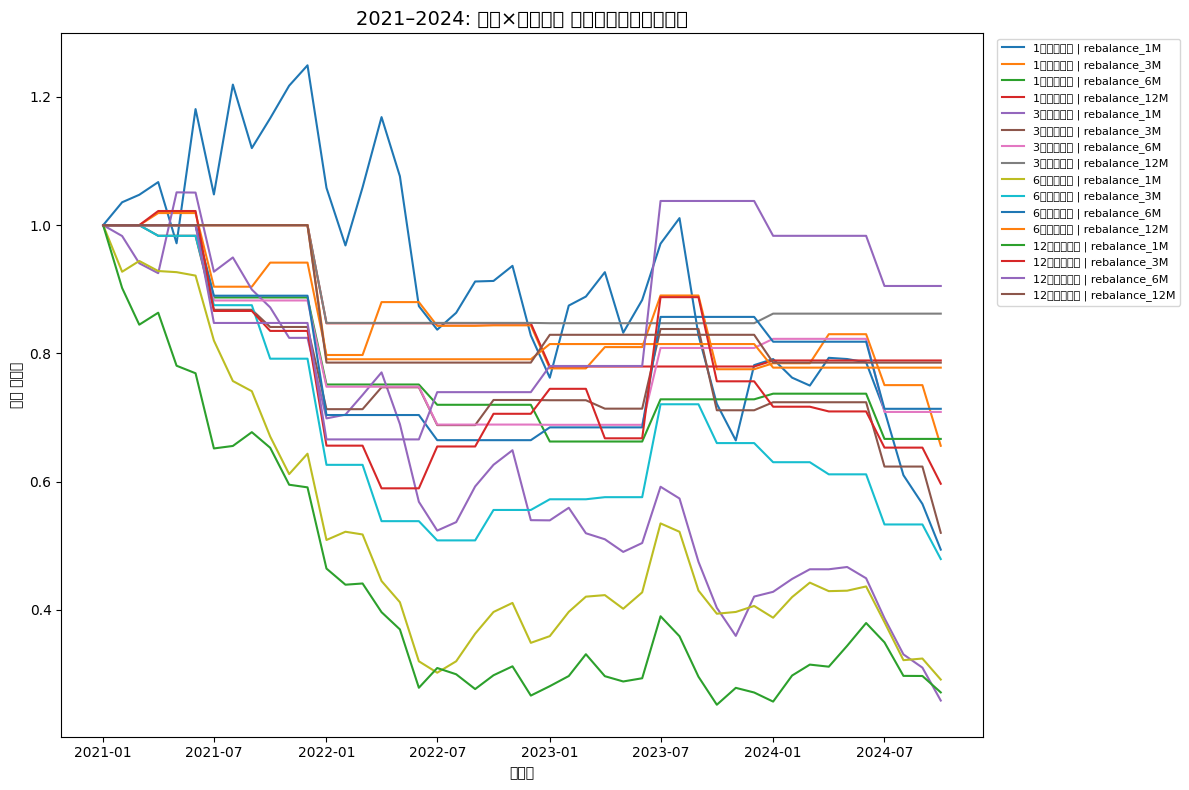


=== 복합 모멘텀(3M+12M) 분기 리밸 Top20 성과 ===
{'CAGR': -0.17875838477973016, 'Sharpe': -1.1780029744256697, 'MDD': -0.49900118506438534}


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List, Dict

# ───────────────────────────────────────────────────────────────────
# 0) 준비: 필요한 함수 정의
# ───────────────────────────────────────────────────────────────────

def compute_performance_metrics(returns: pd.Series, freq: int = 12, rf: float = 0.0) -> Dict[str, float]:
    """
    입력:
        - returns: 월별 포트폴리오 수익률 시계열 (예: 2021-01, 2021-02, ... 형태의 인덱스를 가진 pd.Series)
        - freq: 연간 리턴 계산 빈도 (월별 = 12)
        - rf: 무위험 이자율 (연 단위). Sharpe 계산 시 사용 (여기서는 rf=0.0 로 가정)
    출력:
        - {
            'CAGR': 연평균복리수익률,
            'Sharpe': 샤프비(연 환산),
            'MDD': 최대 낙폭
          }
    """
    # 1) 월별 리턴이 NaN인 달은 제거
    ret = returns.dropna()
    if ret.empty:
        return {'CAGR': np.nan, 'Sharpe': np.nan, 'MDD': np.nan}

    # 2) 누적수익률 시계열 계산 (1 + r1)*(1 + r2)*... 
    cumulative = (1 + ret).cumprod()

    # 3) 전체 기간(년 단위) 계산
    start_date = ret.index.min()
    end_date = ret.index.max()
    # 연 수 계산: (끝-시작).days / 365
    total_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    total_years = total_days / 365.0 if total_days > 0 else 1.0

    # 4) CAGR 계산
    total_return = cumulative.iloc[-1] - 1.0
    CAGR = (cumulative.iloc[-1]) ** (1.0 / total_years) - 1.0

    # 5) 연환산 평균 초과수익률 & 연환산 표준편차 (샤프)
    #    월별 rf는 (1+rf)^(1/12) - 1 이지만, 간단히 rf 연단위 0 가정 or 필요시 수정
    avg_monthly_excess = ret.mean() - rf / freq
    std_monthly = ret.std(ddof=0)
    # 연환산:
    annualized_excess = avg_monthly_excess * freq
    annualized_vol = std_monthly * np.sqrt(freq)
    Sharpe = annualized_excess / annualized_vol if annualized_vol != 0 else np.nan

    # 6) MDD (Max Drawdown)
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    MDD = drawdown.min()

    return {
        'CAGR': float(CAGR),
        'Sharpe': float(Sharpe),
        'MDD': float(MDD)
    }


def backtest_momentum(
    df: pd.DataFrame,
    lookback_col: str,
    rebalance_months: int,
    top_n: int
) -> pd.Series:
    """
    입력:
        - df: 
            • 반드시 다음 컬럼을 포함해야 함: ['종목코드', '기준월', lookback_col, '다음월수익률']
            • '기준월'은 datetime 형, '다음월수익률'은 float
            • lookback_col: 예를 들어 '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률' 등
        - rebalance_months: 리밸런싱 주기 (예: 1, 3, 6, 12)
        - top_n: 매 리밸런싱 시점에 상위 top_n 종목을 뽑을 것
    반환:
        - “연-월”(YYYY-MM)을 인덱스로 갖는 pd.Series 형태의 포트폴리오 월별 리턴 시계열
    """
    # 1) 데이터 복사 및 정렬
    df = df.copy()
    df['기준월'] = pd.to_datetime(df['기준월'])
    df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

    # 2) '연월' 컬럼 생성 (예: 2021-03-01 → '2021-03')
    df['연월'] = df['기준월'].dt.to_period('M').astype(str)

    # 3) 필수 컬럼 체크: lookback_col, 다음월수익률 존재 여부
    if lookback_col not in df.columns:
        raise ValueError(f"필수 컬럼 '{lookback_col}' 가 존재하지 않습니다.")
    if '다음월수익률' not in df.columns:
        raise ValueError("필수 컬럼 '다음월수익률' 이 존재하지 않습니다. 먼저 생성해주세요.")

    # 4) 전체 유니크 '연월' 리스트 생성 (정렬)
    all_months = sorted(df['연월'].unique())

    # 5) 포트폴리오 월별 리턴을 담을 dict 준비
    portfolio_returns = {}

    # 6) 각 월(month_idx)마다 리밸런싱 여부 판단
    #    - month_idx 0부터 시작 → 첫 번째 달은 랭킹 산정 불가(lookback 계산 시점이므로)
    #    - 그 이후로 rebalance_months 간격으로 포트폴리오 재구성
    for i, current_month in enumerate(all_months[:-1]):  # 마지막 달은 다음월수익률이 없을 수도 있으므로 패스
        # (1) i가 0이면, 포트폴리오 구성 불가 → 0 리턴 또는 NaN
        if i == 0:
            portfolio_returns[current_month] = np.nan
            continue

        # (2) 이전 rebalance_months 기간 여부 확인
        if (i % rebalance_months) != 0:
            # 리밸 주기가 아닌 달은 이전 달 포트폴리오와 동일하게 유지 → 같은 수익을 적용
            # → 하지만 여기서는 “매달 리턴을 계산”하기 위해, 재선정하지 않고 이전 포트폴리오 종목의
            #   다음월수익률 평균을 계산해 붙이는 로직을 써도 되지만, 단순하면서 안전한 방법을 택합니다.
            #   (예: monthly rebalancing이 아니면, 해당 달은 그냥 NaN으로 두거나 직전 수익을 반복)
            #   이 예시에서는 “리밸 아닌 달은 NaN” 처리합니다.
            portfolio_returns[current_month] = np.nan
            continue

        # (3) 이 시점(current_month)에 포트폴리오를 새로 구성
        #     (a) current_month 시점의 lookback_col 값이 존재하는 데이터만 사용
        subset = df[df['연월'] == current_month].copy()
        #     (b) lookback_col 기준으로 상위 top_n 종목코드 추출 (내림차순)
        #         ※ 만약 lookback_col 값이 NaN인 종목이 있다면 dropna 후 ranking
        subset = subset.dropna(subset=[lookback_col])
        if subset.empty:
            portfolio_returns[current_month] = np.nan
            continue

        top_stocks = subset.nlargest(top_n, columns=[lookback_col])['종목코드'].tolist()

        # (4) 이 포트폴리오 종목(top_stocks)들의 “다음월수익률” 평균을 구하여
        #     current_month 포트폴리오 리턴으로 기록
        #     “다음월수익률”은 현재 current_month 행의 다음월 수익률이므로,
        #     df 에 기록된 해당 종목의 current_month 행의 '다음월수익률' 사용
        mask = (df['연월'] == current_month) & (df['종목코드'].isin(top_stocks))
        avg_return = df.loc[mask, '다음월수익률'].mean()
        portfolio_returns[current_month] = avg_return

    # 7) Series로 변환
    portf_series = pd.Series(portfolio_returns)
    portf_series.index = pd.to_datetime(portf_series.index + '-01')  # 'YYYY-MM' → 'YYYY-MM-01' 로 변환
    portf_series.name = 'portfolio_return'
    return portf_series


# ───────────────────────────────────────────────────────────────────
# 1) 데이터 로드 및 전처리: '다음월수익률' 컬럼 생성
# ───────────────────────────────────────────────────────────────────

# 예시 경로: 본인의 CSV 파일 경로로 변경하세요!
df = pd.read_csv('/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv')

# 1-1) '기준월'을 datetime으로 변환
df['기준월'] = pd.to_datetime(df['기준월'])

# 1-2) 종목코드별로 정렬
df = df.sort_values(['종목코드', '기준월']).reset_index(drop=True)

# 1-3) '다음월수익률' 생성
#      • 원본에 '1개월수익률' 컬럼이 “현재 월 → 다음 월” 수익률이라 가정
#      • 없으면, 월말 종가가 '종가' 컬럼에 들어 있다고 가정하고 pct_change()로 계산 가능
if '1개월수익률' in df.columns:
    df['다음월수익률'] = df.groupby('종목코드')['1개월수익률'].shift(-1)
else:
    # 예: '종가' 컬럼이 있을 경우
    df['다음월수익률'] = df.groupby('종목코드')['종가'].pct_change().shift(-1)

# 1-4) '다음월수익률'이 NaN인 마지막 월(row) 제거
df = df.dropna(subset=['다음월수익률']).reset_index(drop=True)

# 1-5) '연월' 컬럼 생성 (YYYY-MM 형태)
df['연월'] = df['기준월'].dt.to_period('M').astype(str)


# ───────────────────────────────────────────────────────────────────
# 2) 룰백 기간과 리밸런싱 주기별 백테스트 & 성과 비교
# ───────────────────────────────────────────────────────────────────

# 2-1) 룰백 컬럼 리스트 (원본 df에 컬럼명이 동일해야 합니다.)
lookback_cols = ['1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률']

# 2-2) 리밸런싱 주기 리스트 (개월 단위)
rebalance_freqs = [1, 3, 6, 12]

# 2-3) 백테스트 결과를 저장할 dict 구조 준비
results = {}  # { 'lookback_1M': { rebalance_1: { 'ts': Series, 'perf': dict }, rebalance_3: {...}, ... }, ... }

for lb_col in lookback_cols:
    results[lb_col] = {}
    for freq in rebalance_freqs:
        # (A) 한 번에 백테스트 수행
        portf_ts = backtest_momentum(
            df=df,
            lookback_col=lb_col,
            rebalance_months=freq,
            top_n=20
        )

        # (B) 성과 지표 계산 (2021-01 ~ 2024-12 전체 구간)
        perf = compute_performance_metrics(portf_ts, freq=12, rf=0.0)

        # (C) 저장
        results[lb_col][f"rebalance_{freq}M"] = {
            'ts': portf_ts,
            'perf': perf
        }

# 2-4) 결과 요약 출력
print("=== 룰백 × 리밸런싱 실험 결과 요약 ===")
for lb_col, reb_dict in results.items():
    print(f"\n>>> 룩백: {lb_col}")
    for reb_key, info in reb_dict.items():
        print(f"   - {reb_key}: {info['perf']}")


# ───────────────────────────────────────────────────────────────────
# 3) 룩백 및 리밸런싱별 포트폴리오 리턴 시리즈 시각화 (2021~2024)
# ───────────────────────────────────────────────────────────────────

plt.figure(figsize=(12, 8))
for lb_col, reb_dict in results.items():
    for reb_key, info in reb_dict.items():
        ts = info['ts']
        # 누적수익률 플롯
        cum = (1 + ts.fillna(0)).cumprod()
        plt.plot(cum.index, cum.values, label=f"{lb_col} | {reb_key}")

plt.title("2021–2024: 룩백×리밸런싱 누적포트폴리오수익률", fontsize=14)
plt.legend(fontsize=8, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel("누적 수익률")
plt.xlabel("기준월")
plt.tight_layout()
plt.show()


# ───────────────────────────────────────────────────────────────────
# 4) (선택) 복합 Momentum 지표 도입 예시
# ───────────────────────────────────────────────────────────────────

# 예시: “최근 3개월 수익률”과 “지난 12개월 수익률”을 합산해 복합 모멘텀 지표 생성
df['복합_모멘텀'] = df['3개월수익률'].fillna(0) + df['12개월수익률'].fillna(0)

# 새롭게 생성한 '복합_모멘텀'을 룩백 컬럼으로 쓰려면,
# backtest_momentum 함수 호출 시 lookback_col='복합_모멘텀' 으로 하면 됩니다.
portf_ts_complex = backtest_momentum(
    df=df,
    lookback_col='복합_모멘텀',
    rebalance_months=3,  # 예: 분기마다 리밸
    top_n=20
)
perf_complex = compute_performance_metrics(portf_ts_complex, freq=12, rf=0.0)
print("\n=== 복합 모멘텀(3M+12M) 분기 리밸 Top20 성과 ===")
print(perf_complex)

# ───────────────────────────────────────────────────────────────────
# 5) 무위험 이자율(rf)에 관하여
# ───────────────────────────────────────────────────────────────────
# 현재 코드에서는 rf=0으로 고정해 두었습니다.
# “무위험 이자율을 0으로 가정해도 되는가?” 질문에 대한 간단한 답:
#   - 월별 포트폴리오 수익률이 연간 수익으로 환산될 때, rf를 0으로 두면
#     초과수익률을 동일시해서 샤프비를 계산합니다.
#   - 만약 실제 무위험 이자율(예: 연 1%~2% 수준)을 반영하고 싶다면,
#     compute_performance_metrics() 호출 시 rf=0.01 또는 0.02 등을 넣으면 됩니다.
#   - 그러나 대부분의 사례에서 “샤프비 비교 목적으로” rf를 0으로 가정해도 크게 무리가 없습니다.

# 코드 끝.